In [1]:
# !apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
# !apt-get install texlive texlive-latex-extra texlive-fonts-recommended dvipng
# !pip install latex
!pip install tueplots

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
import os
import glob
import re
import collections
from tueplots import bundles
# mpl.rcParams.update(mpl.rcParamsDefault)
np.set_printoptions(precision=4, suppress = True)
# sns.set_context("paper")
sns.set_context("paper", rc = plt.rcParams.update(bundles.tmlr2023()))
plt.rcParams['text.usetex'] = False
plt.rcParams["figure.figsize"] = (8,5)

In [3]:
def ddict2dict(d):
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = ddict2dict(v)
    return dict(d)
# PARENT_DIR, CURR_FOLD = os.path.split(os.getcwd())
PARENT_DIR = os.getcwd()
DATA_DIR = PARENT_DIR + '/Data_temp'
if not os.path.isdir(PARENT_DIR + '/Paper_plots'):
  os.makedirs(PARENT_DIR + '/Paper_plots')
  
dir = PARENT_DIR + "/Data_temp"
file_list = glob.glob(dir+"/HL3*")
mydict = lambda: collections.defaultdict(mydict)
dic = mydict()
for file in file_list:
  # print(file)
  loss = re.search('ep300_(.*)_d', file).group(1)
  x_var = re.search('x_var_(.*)_[0-9]', file).group(1)
  measure = re.search('_[0-9]_(.*).npy', file).group(1)
  d = re.search('_d_(.*)_x_var'.format(x_var), file).group(1)
  training_num = re.search('_x_var_{}_(.*)_{}'.format(x_var, measure), file).group(1)
  # print(d)
  dic[loss][d][x_var][measure][training_num] = np.load(file).reshape((1,-1))

loss = 'mscr'
d = '0.5'
x_var = '0.01'
measure = 'lip_cr'
training_num = '1'
# dic[loss][d][x_var]
dic[loss][d][x_var][measure][training_num].mean()
loss = 'zhen'
d = '10.0'
x_var = '0.1'
measure = 'lip_cr'
training_num = '1'
dic[loss][d][x_var][measure][training_num]
acc_grid = {}
fix_grid = {}
var_grid = {}
lip_grid = {}
gn_grid = {}
# acc_grid['zhen'] = np.zeros((6,8))
# acc_grid['mscr'] = np.zeros((8,8))
# fix_grid['zhen'] = np.zeros((6,8))
# fix_grid['mscr'] = np.zeros((8,8))
# var_grid['zhen'] = np.zeros((6,8))
# var_grid['mscr'] = np.zeros((8,8))
# lip_grid['zhen'] = np.zeros((6,8))
# lip_grid['mscr'] = np.zeros((8,8))
# gn_grid['zhen'] = np.zeros((6,8))
# gn_grid['mscr'] = np.zeros((8,8))
acc_grid['zhen'] = np.zeros((6,9))
acc_grid['mscr'] = np.zeros((8,9))
fix_grid['zhen'] = np.zeros((6,9))
fix_grid['mscr'] = np.zeros((8,9))
var_grid['zhen'] = np.zeros((6,9))
var_grid['mscr'] = np.zeros((8,9))
lip_grid['zhen'] = np.zeros((6,9))
lip_grid['mscr'] = np.zeros((8,9))
gn_grid['zhen'] = np.zeros((6,9))
gn_grid['mscr'] = np.zeros((8,9))

In [4]:
args_zhen = ['zhen', ["0.01", "0.02", "0.04", "0.08", "0.16", "0.32", "0.64", "1.28", "1.75"], ["5.0", "10.0", "15.0", "20.0", "25.0", "30.0"]]
args_mscr = ['mscr', ["0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05", "0.1", "0.5", "1.0"], ["0.5", "1.0", "1.5", "2.0", "2.5", "3.0", "3.5","4.0"]]

args = [args_zhen, args_mscr]
max_lip_cr = 0
for arg in args:
    loss = arg[0]
    var_arr = arg[1]
    d_arr = arg[2]
    for j, var in enumerate(var_arr):
        for i, d in enumerate(d_arr):
            AUC_avg = 0
            counter = 0
            
            for key, value in dic[loss][d][var]['clean_acc'].items():
                counter += 1
                AUC_avg += value
            
            acc_grid[loss][i,j] = AUC_avg/counter

            AUC_avg = 0
            counter = 0
            for key, value in dic[loss][d][var]['gauss_noise'].items():
                if value[0:3].mean() >= 0.1 and counter <= 2: 
                    aux = value
                    a = 1 - (aux - aux.min())/(aux.max() - aux.min())
                    if (aux.max() - aux.min()) == 0:
                        print(d)
                        print(var)
                        print(key)
                        print(aux.max())
                        print(aux.min())
                    norm_aux = ((1 - a)*aux)/(1 - a*aux)
                    dic[loss][d][var]['noise_dist'][key] = norm_aux
                    dic[loss][d][var]['noise_AUC'][key] = np.sum(0.2*(dic[loss][d][var]['noise_dist'][key][0,0:norm_aux.shape[1]-1]+dic[loss][d][var]['noise_dist'][key][0,1:norm_aux.shape[1]])/2)
                    AUC_avg += dic[loss][d][var]['noise_AUC'][key]
                    counter += 1
            gn_grid[loss][i,j] = AUC_avg/counter
            
            AUC_avg = 0
            counter = 0
            for key, value in dic[loss][d][var]['lip_cr'].items():
                if value.mean() >= 0.0001 and counter <= 2: 
                    aux = value
                    max_lip_cr = np.max((max_lip_cr,aux.max()))
                    lip_acc = []
                    for radius in np.arange(0, 10.0, 0.05):
                        lip_acc.append(aux[aux > radius].shape[0])
                    temp = np.asarray(lip_acc)/10000
                    dic[loss][d][var]['lip_dist'][key] = temp
                    dic[loss][d][var]['lip_AUC'][key] = np.sum(0.05*(dic[loss][d][var]['lip_dist'][key][0:199]+dic[loss][d][var]['lip_dist'][key][1:200])/2)
                    AUC_avg += dic[loss][d][var]['lip_AUC'][key]
                    counter += 1
            
            lip_grid[loss][i,j] = AUC_avg/counter
            
            AUC_avg = 0
            counter = 0
            for key, value in dic[loss][d][var]['rs_cr_fixed'].items():
                if value.mean() >= 0.0001 and counter <= 2:        
                    aux = value
                    RS_acc = []
                    for radius in np.arange(0, 1.056, 0.0066):
                        RS_acc.append(value[value > radius].shape[0])
                    dic[loss][d][var]['fix_dist'][key] = np.asarray(RS_acc)/10000
                    dic[loss][d][var]['fix_AUC'][key] = np.sum(0.0066*(dic[loss][d][var]['fix_dist'][key][0:159]+dic[loss][d][var]['fix_dist'][key][1:160])/2)
                    AUC_avg += dic[loss][d][var]['fix_AUC'][key]
                    counter += 1
                
            fix_grid[loss][i,j] = AUC_avg/counter


In [5]:
args_zhen1 = ['zhen', ["0.08"], ["15.0"]]
args_zhen2 = ['zhen', ["0.64"], ["15.0"]]
args_mscr1 = ['mscr', ["0.1"], ["1.0"]]
args_mscr2 = ['mscr', ["0.01"], ["3.5"]]
args_mcr1 = ['mcr', ["0.0"], ["1.0"]]
args_mcr2 = ['mcr', ["0.0"], ["3.5"]]
args_mch = ['mc_hinge', ["0.0"], ["3.0"]]
args_sce = ['sce', ["0.0"], ["0.0"]]
args_scsce = ['scsce', ["0.01"], ["0.0"]]
results = {'mc_hinge_3.0': {}, 'sce_0.0': {},'scsce_0.0': {},'mcr_1.0': {}, 'mcr_3.5': {},'mscr_1.0': {}, 'mscr_3.5': {},'zhen_15.0': {}, 'zhen_30.0': {}}

args = [args_zhen1, args_mscr1, args_mcr1, args_zhen2, args_mscr2, args_mcr2, args_mch, args_sce, args_scsce]
max_lip_cr = 0
for arg in args:
    loss = arg[0]
    var_arr = arg[1]
    d_arr = arg[2]
    for j, var in enumerate(var_arr):
        for i, d in enumerate(d_arr):
            mat_lip = np.zeros((3,500))
            mat_rs = np.zeros((3,500))
            mat_gn = np.ones((3,500))*0.1
            mat_ssnr = np.zeros((3,500))

            counter = 0
            for key, value in dic[loss][d][var]['gauss_noise'].items():
                if value[0:3].mean() < 0.01 or counter > 2:
                    pass
                else:   
                    aux = value
                    dic[loss][d][var]['noise_dist'][key] = aux
                    mat_gn[counter,:value.flatten().shape[0]] = value.flatten()
                counter += 1

            AUC_avg = 0
            counter = 0            
            for key, value in dic[loss][d][var]['SSNR_acc'].items():
                if counter <= 2:            
                    dic[loss][d][var]['ssnr_dist'][key] = value
                    mat_ssnr[counter,:value.flatten().shape[0]] = value.flatten()
                counter += 1
                
            AUC_avg = 0
            counter = 0
            for key, value in dic[loss][d][var]['lip_cr'].items():
                if value.mean() < 0.01 or counter > 2:
                    pass
                else:   
                    aux = value
                    max_lip_cr = np.max((max_lip_cr,aux.max()))
                    lip_acc = []
                    for radius in np.arange(0, 6.0, 0.08):
                        lip_acc.append(aux[aux > radius].shape[0])
                    temp = np.asarray(lip_acc)/10000
                    dic[loss][d][var]['lip_dist'][key] = temp
                    mat_lip[counter,:temp.flatten().shape[0]] = temp.flatten()
                counter += 1

            AAC_avg = 0
            counter = 0
            for key, value in dic[loss][d][var]['rs_cr_fixed'].items():
                if value.mean() < 0.01 or counter > 2:
                    pass
                else:          
                    aux = value
                    RS_acc = []
                    for radius in np.arange(0, 1.056, 0.066):
                        RS_acc.append(value[value > radius].shape[0])
                    temp = np.asarray(RS_acc)/10000
                    dic[loss][d][var]['rs_cr_fixed'][key] = temp
                    mat_rs[counter,:temp.flatten().shape[0]] = temp.flatten()
                    counter += 1
                
                
            results['{}_{}'.format(loss,d)]['ssnr'] = mat_ssnr
            results['{}_{}'.format(loss,d)]['gn'] = mat_gn
            results['{}_{}'.format(loss,d)]['lip'] = mat_lip
            results['{}_{}'.format(loss,d)]['rs'] = mat_rs
            

In [6]:
results['scsce_0.0']['ssnr']

array([[1.    , 0.9988, 0.9975, ..., 0.    , 0.    , 0.    ],
       [1.    , 0.9986, 0.997 , ..., 0.    , 0.    , 0.    ],
       [1.    , 0.9989, 0.9976, ..., 0.    , 0.    , 0.    ]])

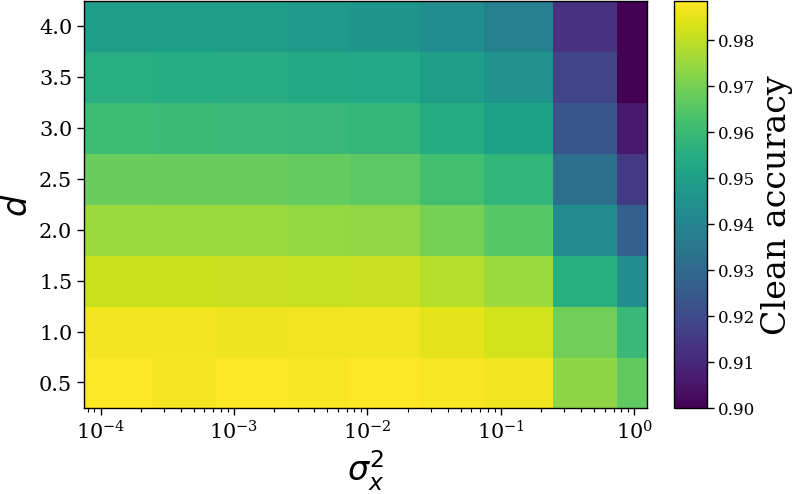

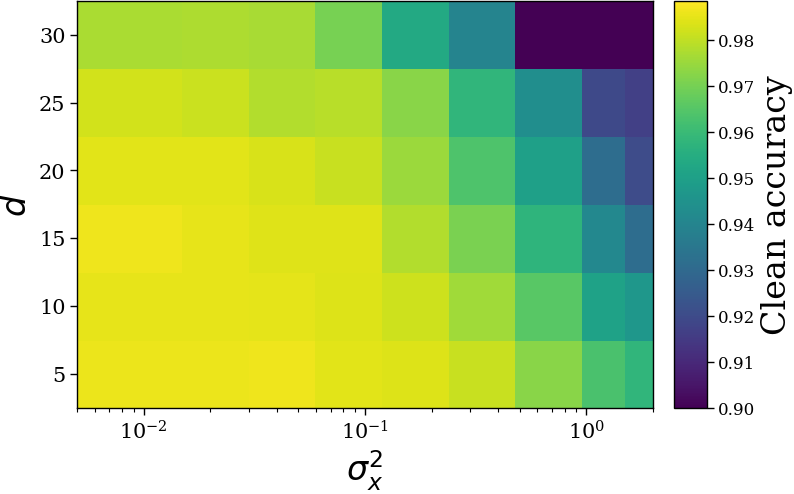

In [7]:
stats_label = ["Clean accuracy"]
stats_name = ['clean_acc']
i = 0
z1 = acc_grid["mscr"]
z2 = acc_grid["zhen"]

z_min, z_max = np.min((z1.min(), z2.min())), np.max((z1.max(), z2.max()))
z_min = 0.9
c_map = plt.cm.viridis(np.linspace(0, 1, 100))

# x_var_arr = [0.00075, 0.0025, 0.0075, 0.025, 0.075, 0.25, 0.75, 1.25]
x_var_arr = [0.000075, 0.00025, 0.00075, 0.0025, 0.0075, 0.025, 0.075, 0.25, 0.75, 1.25]
d_arr = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25]
# x_var_arr = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
# d_arr = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
y, x = np.meshgrid(d_arr, x_var_arr)
fig, ax = plt.subplots(dpi=100)
c = ax.pcolormesh(x, y, z1.T, vmin=z_min, vmax=z_max, cmap = 'viridis')
ax.set_ylabel('$d$', fontsize=24)
ax.set_xlabel('$\sigma_x^2$', fontsize=24)
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
if (z1[z1.argmax()//z1.shape[1],z1.argmax()%z1.shape[1]] - z_min)/(z_max - z_min) >= 0.5:
  c_map_aux = 'black'
else:
  c_map_aux = 'white'
ax.axis([x.min(), x.max(), y.min(), y.max()])
cb = fig.colorbar(c, ax=ax)
cb.set_label(label = stats_label[0],size=24)
cb.ax.tick_params(labelsize=12)
plt.savefig(PARENT_DIR + '/Paper_plots/_{}_mscr_cmap_dXx_var.png'.format(stats_name[0]), bbox_inches='tight', dpi = 600)
plt.show()

x_var_arr = [0.005, 0.015, 0.03, 0.06, 0.12, 0.24, 0.48, 0.96, 1.50, 2.0]
d_arr = [2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5]
# x_var_arr = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 1.75]
# d_arr = [5., 10., 15., 20., 25., 30.]
y, x = np.meshgrid(d_arr, x_var_arr)
fig, ax = plt.subplots(dpi=100)
c = ax.pcolormesh(x, y, z2.T, vmin=z_min, vmax=z_max, cmap = 'viridis')
ax.set_ylabel('$d$', fontsize=24)
ax.set_xlabel('$\sigma_x^2$', fontsize=24)
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
if (z2[z2.argmax()//z2.shape[1],z2.argmax()%z2.shape[1]] - z_min)/(z_max - z_min) >= 0.5:
  c_map_aux = 'black'
else:
  c_map_aux = 'white'
ax.axis([x.min(), x.max(), y.min(), y.max()])
cb = fig.colorbar(c, ax=ax)
cb.set_label(label = stats_label[0],size=24)
cb.ax.tick_params(labelsize=12)
plt.savefig(PARENT_DIR + '/Paper_plots/_{}_zhen_cmap_dXx_var.png'.format(stats_name[0]), bbox_inches='tight', dpi = 600)
plt.show()

In [11]:
fix_mscr = np.copy(fix_grid['mscr'])
fix_zhen = np.copy(fix_grid['zhen'])
fix_mscr[acc_grid['mscr'] <= 0.952] = 0
fix_zhen[acc_grid['zhen'] <= 0.952] = 0
fix_mscr[acc_grid['mscr'] > 0.958] = 0
fix_zhen[acc_grid['zhen'] > 0.958] = 0
# idx_mscr = acc_mscr.astype('bool')
# idx_zhen = acc_zhen.astype('bool')
print(fix_mscr)
print(fix_zhen)

[[0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.8424 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.8544 0.     0.    ]
 [0.     0.     0.     0.     0.     0.8487 0.     0.     0.    ]
 [0.8424 0.8425 0.8428 0.8434 0.8422 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]
[[0.     0.     0.     0.     0.     0.     0.     0.     0.8112]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.8363 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.8389 0.     0.     0.    ]
 [0.     0.     0.     0.     0.7467 0.     0.     0.     0.    ]]


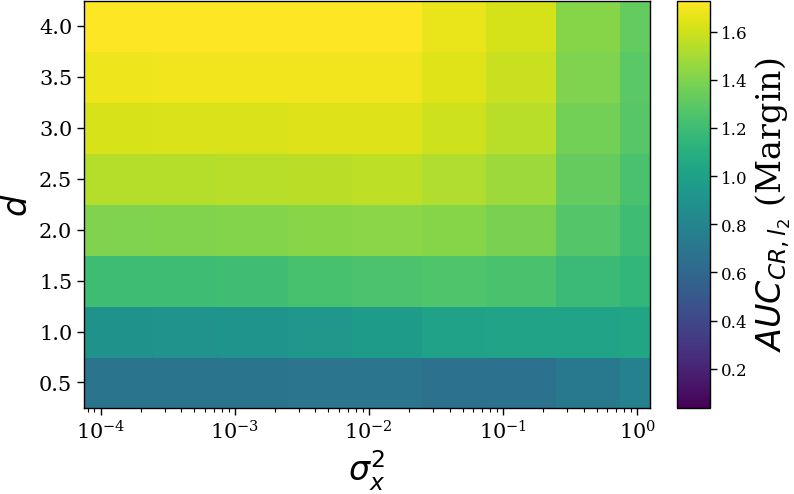

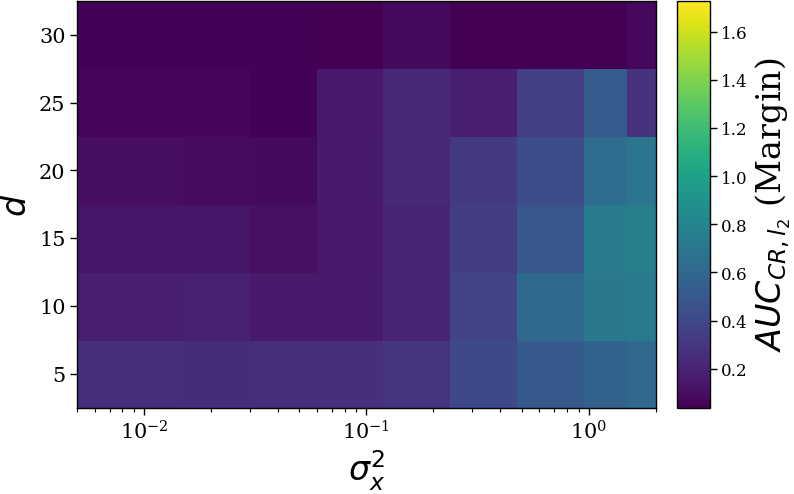

In [ ]:
stats_label = ['$AUC_{CR, l_2}$ (Margin)']
stats_name = ['lip_AUC']
i = 0
z1 = lip_grid["mscr"]
z2 = lip_grid["zhen"]
# z1 = fix_grid["mscr"]
# z2 = fix_grid["zhen"]
# z1 = var_grid["mscr"]
# z2 = var_grid["zhen"]
z_min, z_max = np.min((z1.min(), z2.min())), np.max((z1.max(), z2.max()))
# z_min = 0.9
c_map = plt.cm.viridis(np.linspace(0, 1, 100))
# x_var_arr = [0.00075, 0.0025, 0.0075, 0.025, 0.075, 0.25, 0.75, 1.25]
x_var_arr = [0.000075, 0.00025, 0.00075, 0.0025, 0.0075, 0.025, 0.075, 0.25, 0.75, 1.25]
d_arr = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25]
# x_var_arr = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
# d_arr = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
y, x = np.meshgrid(d_arr, x_var_arr)
fig, ax = plt.subplots(dpi=100)
c = ax.pcolormesh(x, y, z1.T, vmin=z_min, vmax=z_max, cmap = 'viridis')
ax.set_ylabel('$d$', fontsize=24)
ax.set_xlabel('$\sigma_x^2$', fontsize=24)
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
if (z1[z1.argmax()//z1.shape[1],z1.argmax()%z1.shape[1]] - z_min)/(z_max - z_min) >= 0.5:
  c_map_aux = 'black'
else:
  c_map_aux = 'white'
ax.axis([x.min(), x.max(), y.min(), y.max()])
cb = fig.colorbar(c, ax=ax)
cb.set_label(label = stats_label[0],size=24)
cb.ax.tick_params(labelsize=12)
plt.savefig(PARENT_DIR + '/Paper_plots/_{}_mscr_cmap_dXx_var.png'.format(stats_name[0]), bbox_inches='tight', dpi = 600)
plt.show()

x_var_arr = [0.005, 0.015, 0.03, 0.06, 0.12, 0.24, 0.48, 0.96, 1.50, 2.0]
d_arr = [2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5]
# x_var_arr = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 1.75]
# d_arr = [5., 10., 15., 20., 25., 30.]
y, x = np.meshgrid(d_arr, x_var_arr)
fig, ax = plt.subplots(dpi=100)
c = ax.pcolormesh(x, y, z2.T, vmin=z_min, vmax=z_max, cmap = 'viridis')
ax.set_ylabel('$d$', fontsize=24)
ax.set_xlabel('$\sigma_x^2$', fontsize=24)
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
if (z2[z2.argmax()//z2.shape[1],z2.argmax()%z2.shape[1]] - z_min)/(z_max - z_min) >= 0.5:
  c_map_aux = 'black'
else:
  c_map_aux = 'white'
ax.axis([x.min(), x.max(), y.min(), y.max()])
cb = fig.colorbar(c, ax=ax)
cb.set_label(label = stats_label[0],size=24)
cb.ax.tick_params(labelsize=12)
plt.savefig(PARENT_DIR + '/Paper_plots/_{}_zhen_cmap_dXx_var.png'.format(stats_name[0]), bbox_inches='tight', dpi = 600)
plt.show()


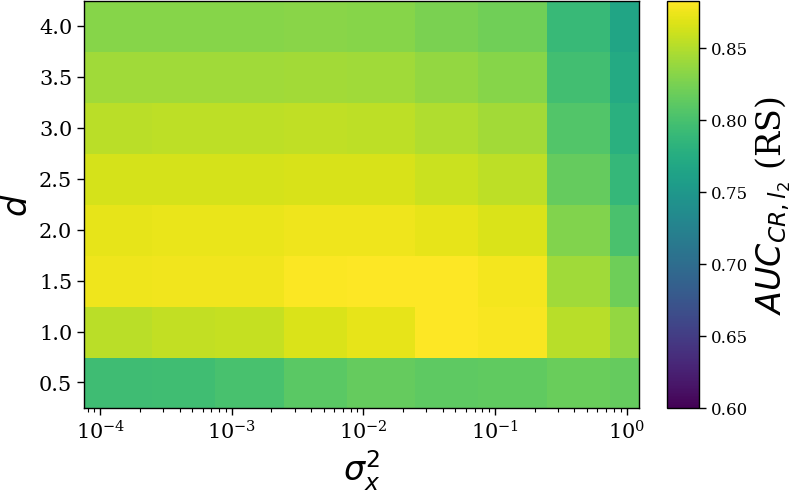

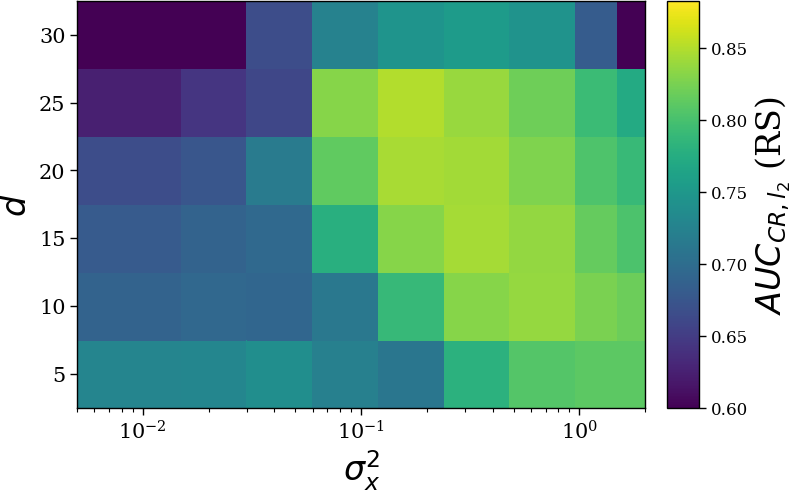

In [ ]:
stats_label = ['$AUC_{CR, l_2}$ (RS)']
stats_name = ['rs_fixed_AUC']
i = 0
z1 = fix_grid["mscr"]
z2 = fix_grid["zhen"]
# z1 = var_grid["mscr"]
# z2 = var_grid["zhen"]
z_min, z_max = np.min((z1.min(), z2.min())), np.max((z1.max(), z2.max()))
z_min = 0.6
c_map = plt.cm.viridis(np.linspace(0, 1, 100))
# x_var_arr = [0.00075, 0.0025, 0.0075, 0.025, 0.075, 0.25, 0.75, 1.25]
x_var_arr = [0.000075, 0.00025, 0.00075, 0.0025, 0.0075, 0.025, 0.075, 0.25, 0.75, 1.25]
d_arr = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25]
# x_var_arr = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
# d_arr = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
y, x = np.meshgrid(d_arr, x_var_arr)
fig, ax = plt.subplots(dpi=100)
c = ax.pcolormesh(x, y, z1.T, vmin=z_min, vmax=z_max, cmap = 'viridis')
ax.set_ylabel('$d$', fontsize=24)
ax.set_xlabel('$\sigma_x^2$', fontsize=24)
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
if (z1[z1.argmax()//z1.shape[1],z1.argmax()%z1.shape[1]] - z_min)/(z_max - z_min) >= 0.5:
  c_map_aux = 'black'
else:
  c_map_aux = 'white'
ax.axis([x.min(), x.max(), y.min(), y.max()])
cb = fig.colorbar(c, ax=ax)
cb.set_label(label = stats_label[0],size=24)
cb.ax.tick_params(labelsize=12)
plt.savefig(PARENT_DIR + '/Paper_plots/_{}_mscr_cmap_dXx_var.png'.format(stats_name[0]), bbox_inches='tight', dpi = 600)
plt.show()

x_var_arr = [0.005, 0.015, 0.03, 0.06, 0.12, 0.24, 0.48, 0.96, 1.50, 2.0]
d_arr = [2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5]
# x_var_arr = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 1.75]
# d_arr = [5., 10., 15., 20., 25., 30.]
y, x = np.meshgrid(d_arr, x_var_arr)
fig, ax = plt.subplots(dpi=100)
c = ax.pcolormesh(x, y, z2.T, vmin=z_min, vmax=z_max, cmap = 'viridis')
ax.set_ylabel('$d$', fontsize=24)
ax.set_xlabel('$\sigma_x^2$', fontsize=24)
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
if (z2[z2.argmax()//z2.shape[1],z2.argmax()%z2.shape[1]] - z_min)/(z_max - z_min) >= 0.5:
  c_map_aux = 'black'
else:
  c_map_aux = 'white'
ax.axis([x.min(), x.max(), y.min(), y.max()])
cb = fig.colorbar(c, ax=ax)
cb.set_label(label = stats_label[0],size=24)
cb.ax.tick_params(labelsize=12)
plt.savefig(PARENT_DIR + '/Paper_plots/_{}_zhen_cmap_dXx_var.png'.format(stats_name[0]), bbox_inches='tight', dpi = 600)
plt.show()


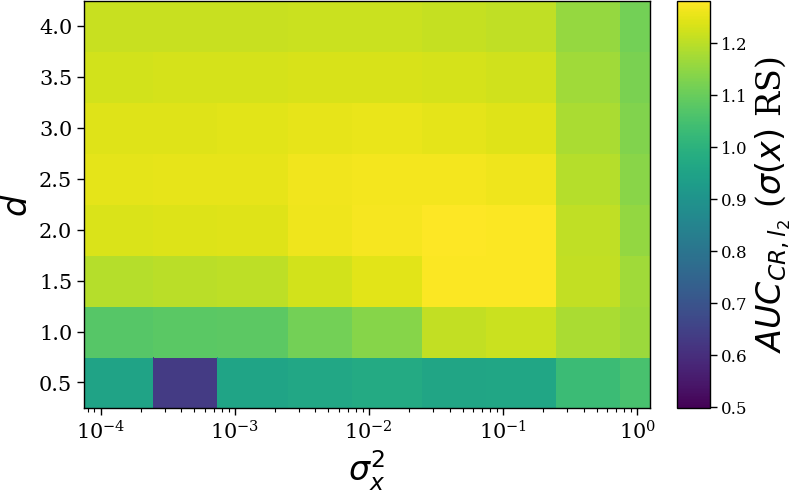

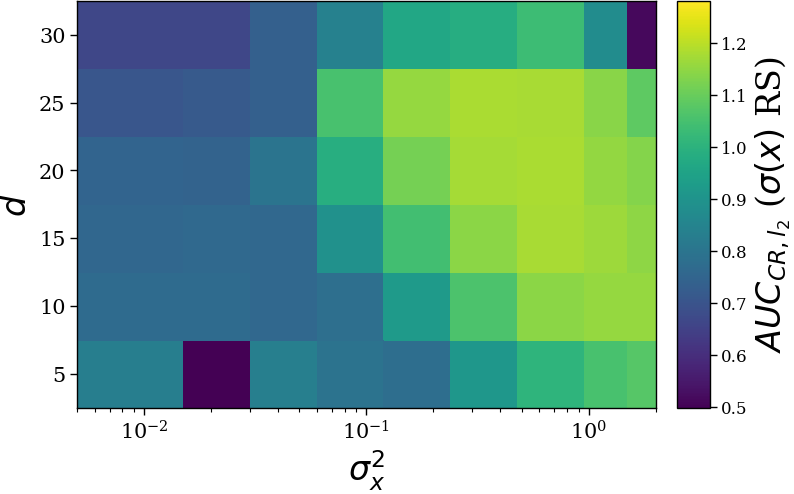

In [ ]:
stats_label = ['$AUC_{CR, l_2}$ ($\sigma(x)$ RS)']
stats_name = ['rs_varied_AUC']
i = 0
z1 = var_grid["mscr"]
z2 = var_grid["zhen"]
z_min, z_max = np.min((z1.min(), z2.min())), np.max((z1.max(), z2.max()))
# z_min = 0.9
c_map = plt.cm.viridis(np.linspace(0, 1, 100))
# x_var_arr = [0.00075, 0.0025, 0.0075, 0.025, 0.075, 0.25, 0.75, 1.25]
x_var_arr = [0.000075, 0.00025, 0.00075, 0.0025, 0.0075, 0.025, 0.075, 0.25, 0.75, 1.25]
d_arr = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25]
# x_var_arr = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
# d_arr = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
y, x = np.meshgrid(d_arr, x_var_arr)
fig, ax = plt.subplots(dpi=100)
c = ax.pcolormesh(x, y, z1.T, vmin=z_min, vmax=z_max, cmap = 'viridis')
ax.set_ylabel('$d$', fontsize=24)
ax.set_xlabel('$\sigma_x^2$', fontsize=24)
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
if (z1[z1.argmax()//z1.shape[1],z1.argmax()%z1.shape[1]] - z_min)/(z_max - z_min) >= 0.5:
  c_map_aux = 'black'
else:
  c_map_aux = 'white'
ax.axis([x.min(), x.max(), y.min(), y.max()])
cb = fig.colorbar(c, ax=ax)
cb.set_label(label = stats_label[0],size=24)
cb.ax.tick_params(labelsize=12)
plt.savefig(PARENT_DIR + '/Paper_plots/_{}_mscr_cmap_dXx_var.png'.format(stats_name[0]), bbox_inches='tight', dpi = 600)
plt.show()

x_var_arr = [0.005, 0.015, 0.03, 0.06, 0.12, 0.24, 0.48, 0.96, 1.50, 2.0]
d_arr = [2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5]
# x_var_arr = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 1.75]
# d_arr = [5., 10., 15., 20., 25., 30.]
y, x = np.meshgrid(d_arr, x_var_arr)
fig, ax = plt.subplots(dpi=100)
c = ax.pcolormesh(x, y, z2.T, vmin=z_min, vmax=z_max, cmap = 'viridis')
ax.set_ylabel('$d$', fontsize=24)
ax.set_xlabel('$\sigma_x^2$', fontsize=24)
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
if (z2[z2.argmax()//z2.shape[1],z2.argmax()%z2.shape[1]] - z_min)/(z_max - z_min) >= 0.5:
  c_map_aux = 'black'
else:
  c_map_aux = 'white'
ax.axis([x.min(), x.max(), y.min(), y.max()])
cb = fig.colorbar(c, ax=ax)
cb.set_label(label = stats_label[0],size=24)
cb.ax.tick_params(labelsize=12)
plt.savefig(PARENT_DIR + '/Paper_plots/_{}_zhen_cmap_dXx_var.png'.format(stats_name[0]), bbox_inches='tight', dpi = 600)
plt.show()


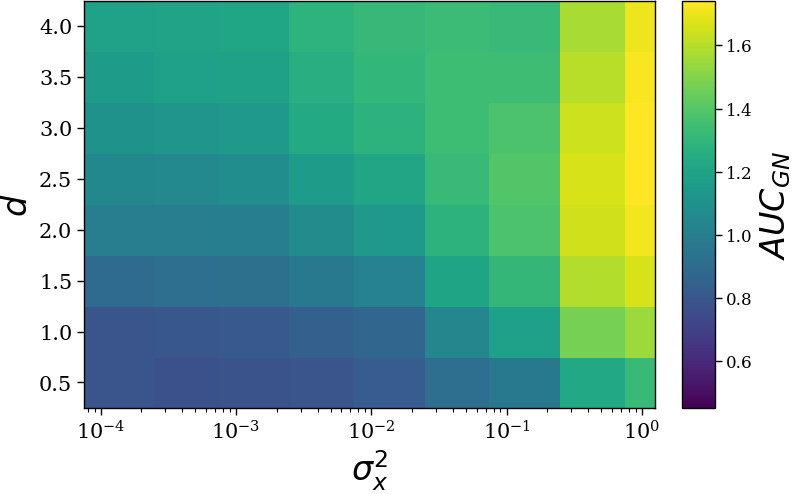

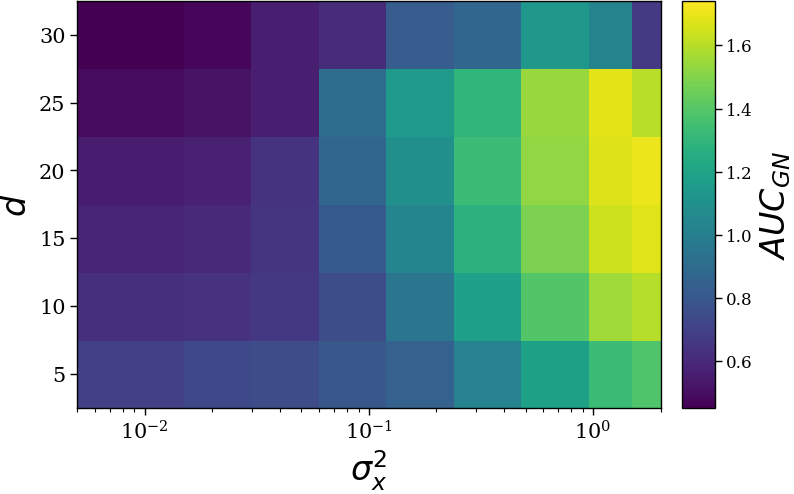

In [ ]:
stats_label = ['$AUC_{GN}$']
stats_name = ['gn_AUC']
i = 0
z1 = gn_grid["mscr"]
z2 = gn_grid["zhen"]
z_min, z_max = np.min((z1.min(), z2.min())), np.max((z1.max(), z2.max()))
# z_min = 0.45
c_map = plt.cm.viridis(np.linspace(0, 1, 100))
# x_var_arr = [0.00075, 0.0025, 0.0075, 0.025, 0.075, 0.25, 0.75, 1.25]
x_var_arr = [0.000075, 0.00025, 0.00075, 0.0025, 0.0075, 0.025, 0.075, 0.25, 0.75, 1.25]
d_arr = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25]
# x_var_arr = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
# d_arr = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
y, x = np.meshgrid(d_arr, x_var_arr)
fig, ax = plt.subplots(dpi=100)
c = ax.pcolormesh(x, y, z1.T, vmin=z_min, vmax=z_max, cmap = 'viridis')
ax.set_ylabel('$d$', fontsize=24)
ax.set_xlabel('$\sigma_x^2$', fontsize=24)
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
if (z2[z2.argmax()//z2.shape[1],z2.argmax()%z2.shape[1]] - z_min)/(z_max - z_min) >= 0.5:
  c_map_aux = 'black'
else:
  c_map_aux = 'white'
ax.axis([x.min(), x.max(), y.min(), y.max()])
cb = fig.colorbar(c, ax=ax)
cb.set_label(label = stats_label[0],size=24)
cb.ax.tick_params(labelsize=12)
plt.savefig(PARENT_DIR + '/Paper_plots/_{}_mscr_cmap_dXx_var.png'.format(stats_name[0]), bbox_inches='tight', dpi = 600)
plt.show()

x_var_arr = [0.005, 0.015, 0.03, 0.06, 0.12, 0.24, 0.48, 0.96, 1.50, 2.0]
d_arr = [2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5]
# x_var_arr = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 1.75]
# d_arr = [5., 10., 15., 20., 25., 30.]
y, x = np.meshgrid(d_arr, x_var_arr)
fig, ax = plt.subplots(dpi=100)
c = ax.pcolormesh(x, y, z2.T, vmin=z_min, vmax=z_max, cmap = 'viridis')
ax.set_ylabel('$d$', fontsize=24)
ax.set_xlabel('$\sigma_x^2$', fontsize=24)
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
if (z2[z2.argmax()//z2.shape[1],z2.argmax()%z2.shape[1]] - z_min)/(z_max - z_min) >= 0.5:
  c_map_aux = 'black'
else:
  c_map_aux = 'white'
ax.axis([x.min(), x.max(), y.min(), y.max()])
cb = fig.colorbar(c, ax=ax)
cb.set_label(label = stats_label[0],size=24)
cb.ax.tick_params(labelsize=12)
plt.savefig(PARENT_DIR + '/Paper_plots/_{}_zhen_cmap_dXx_var.png'.format(stats_name[0]), bbox_inches='tight', dpi = 600)
plt.show()


In [ ]:
noise_acc_data = np.load(dir + '/noise_accxsample_size.npy')
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Samples', fontsize=24)
ax.set_ylabel('Mean noise accuracy (%)', fontsize=24)
# ax.set_xlim(left = -0.1, right = 6.1)
ax.set_xscale('log')
ax.set_ylim(bottom = 38, top = 39.3)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_axis = np.asarray([1,5,10,50,100,500,1000])
line1 = ax.errorbar(x_axis, 100*np.mean(noise_acc_data,axis = 0),100*np.std(noise_acc_data,axis = 0),  color = 'xkcd:black', linestyle = "-", linewidth = 6)
# legend = ax.legend((line1[0], line2[0], line3[0]), ("MCR $d=1.0$", "MSCR ($d=1.0,\sigma_x^2=0.1)$","Zhen $(d=15.0,\sigma_x^2=0.08)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/gauss_noise_accXsamples.png', bbox_inches='tight', dpi = 600)
plt.show()

In [ ]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Samples', fontsize=24)
ax.set_ylabel('Mean noise accuracy (%)', fontsize=24)
# ax.set_xlim(left = -0.1, right = 6.1)
ax.set_xscale('log')
ax.set_ylim(bottom = 38, top = 39.3)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_axis = np.asarray([1,5,10,50,100,500,1000])
line1 = ax.errorbar(x_axis, 100*np.mean(noise_acc_data,axis = 0),100*np.std(noise_acc_data,axis = 0),  color = 'xkcd:black', linestyle = "-", linewidth = 6)
# legend = ax.legend((line1[0], line2[0], line3[0]), ("MCR $d=1.0$", "MSCR ($d=1.0,\sigma_x^2=0.1)$","Zhen $(d=15.0,\sigma_x^2=0.08)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/gauss_noise_accXsamples.png', bbox_inches='tight', dpi = 600)
plt.show()

In [ ]:
measure = ['rs_cr_fixed', 'lip_cr', 'noise_dist', 'SSNR_acc']
arg_arr = [['mcr', '1.0', '0.0'], ['mcr', '3.5', '0.0'], ['mscr', '1.0', '0.1'], ['mscr', '3.5', '0.01'], ['zhen', '15.0', '0.08'], ['zhen', '30.0', '0.16']]
results = {'mcr_1.0': {}, 'mcr_3.5': {},'mscr_1.0': {}, 'mscr_3.5': {},'zhen_15.0': {}, 'zhen_30.0': {}}

for ms in measure:
    for args in arg_arr:
        aux_mat = np.zeros((3,200))
        count = 0
        for key, value in dic[args[0]][args[1]][args[2]][ms].items():
            aux_mat[count,:np.flatten(value).shape[0]] = np.flatten(value)
            count +=1 
        results['{}_{}'.format(args[0],args[1])][ms] = aux_mat
            

mcr
(1, 21)
(1, 21)
(1, 21)


In [ ]:
sce_lip = np.zeros((3,21))
# idx = ['0', '1', '2']
idx = ['1', '2', '3']
# idx = ['3', '4', '5']
for i in idx:
    sce_lip[int(i)-1,:dic[loss][d][x_var][measure][i].shape[1]] = dic[loss][d][x_var][measure][i]
    # zhen_ssnr2[int(i),:dic[loss][d][x_var][measure][i].shape[0]] = dic[loss][d][x_var][measure][i]
    # zhen_fix1[int(i)-3,:dic[loss][d][x_var][measure][i].shape[0]] = dic[loss][d][x_var][measure][i]

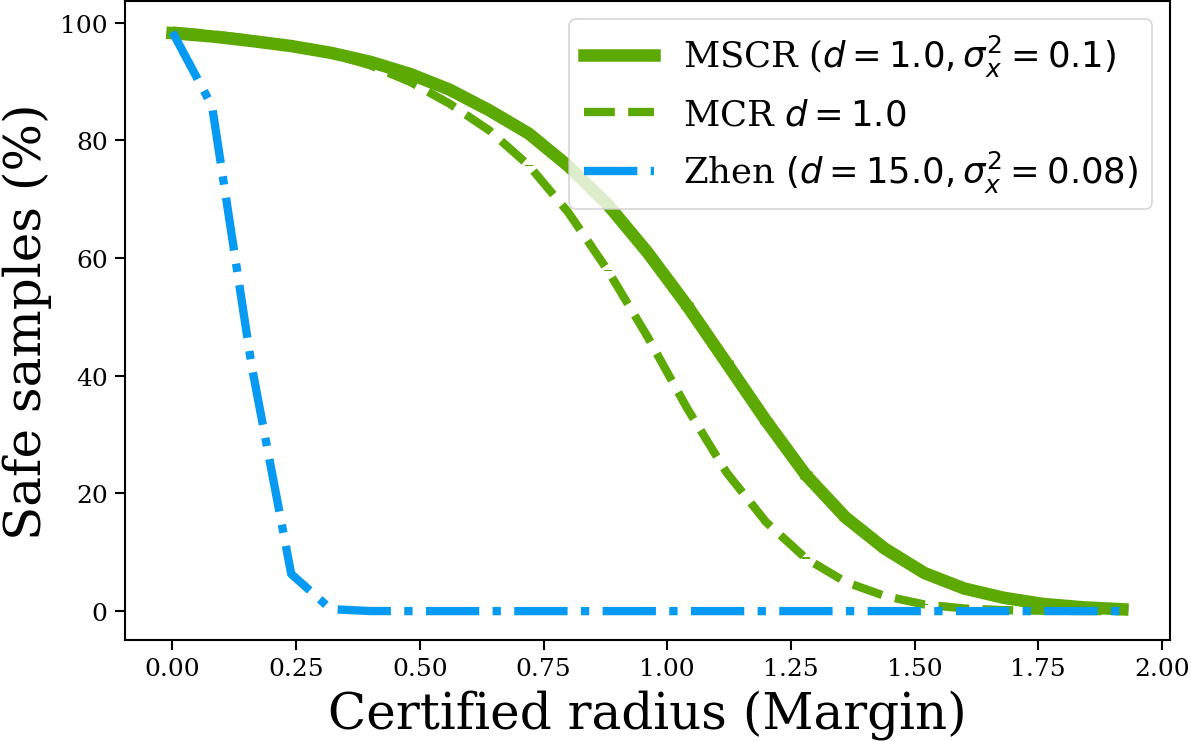

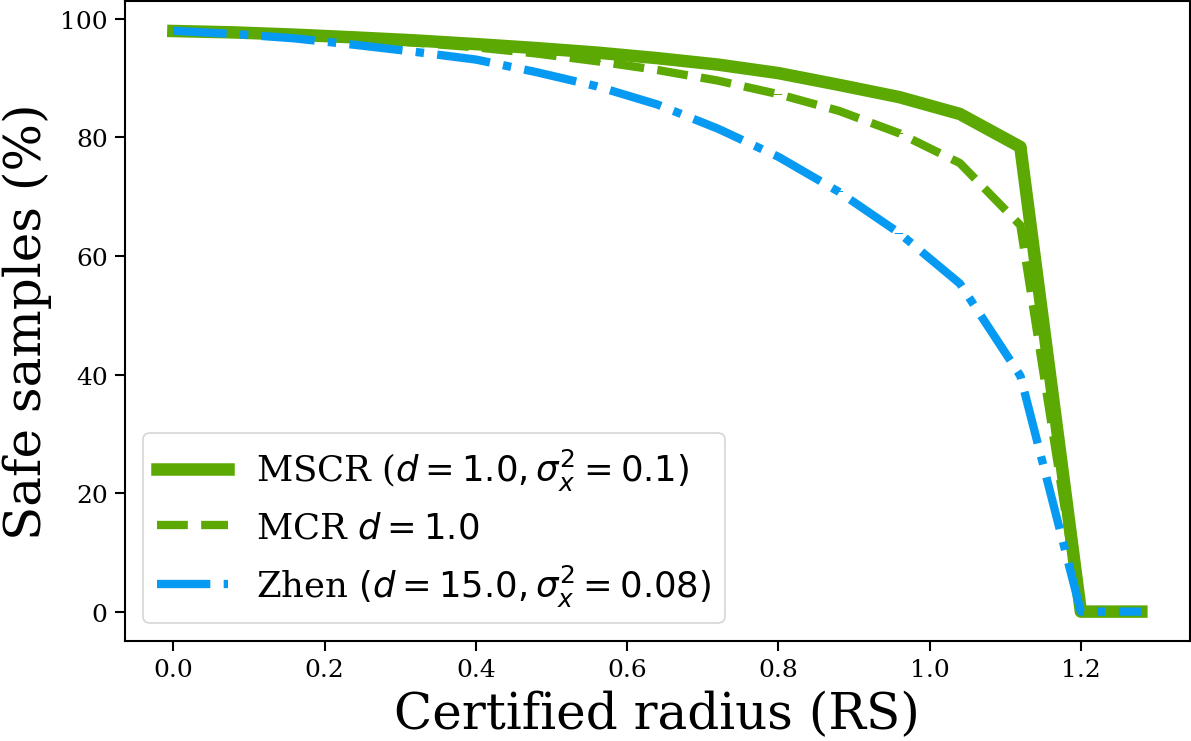

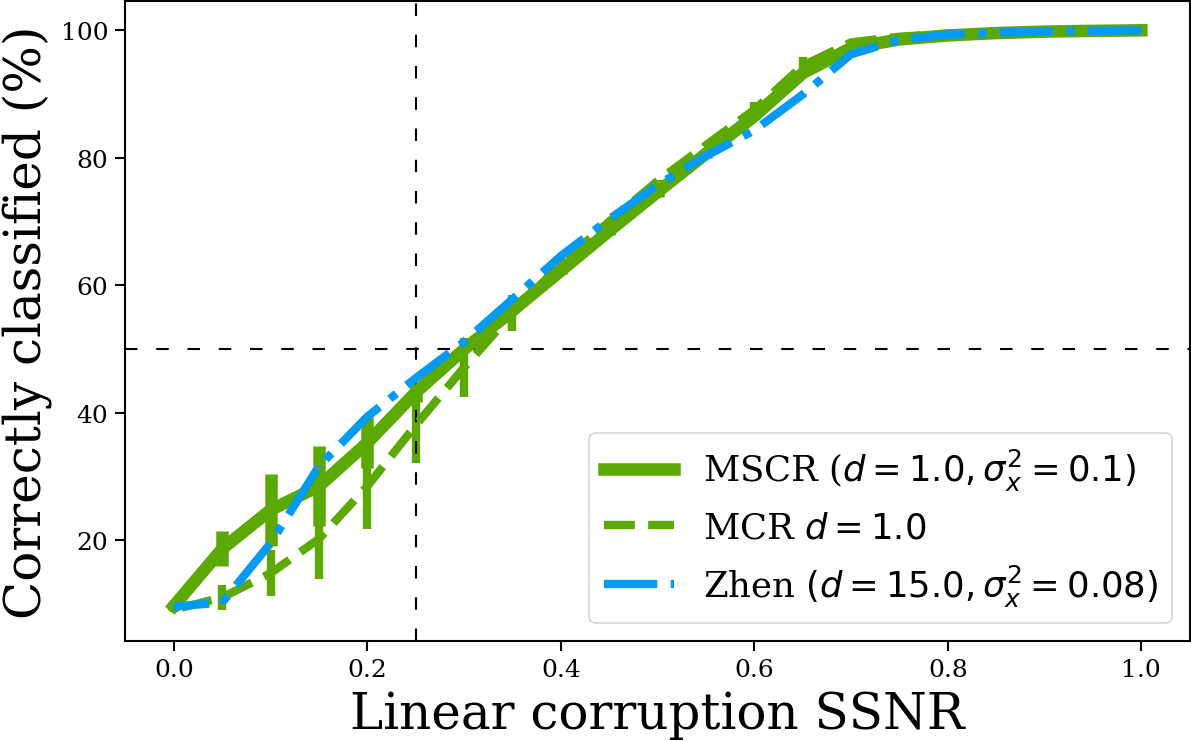

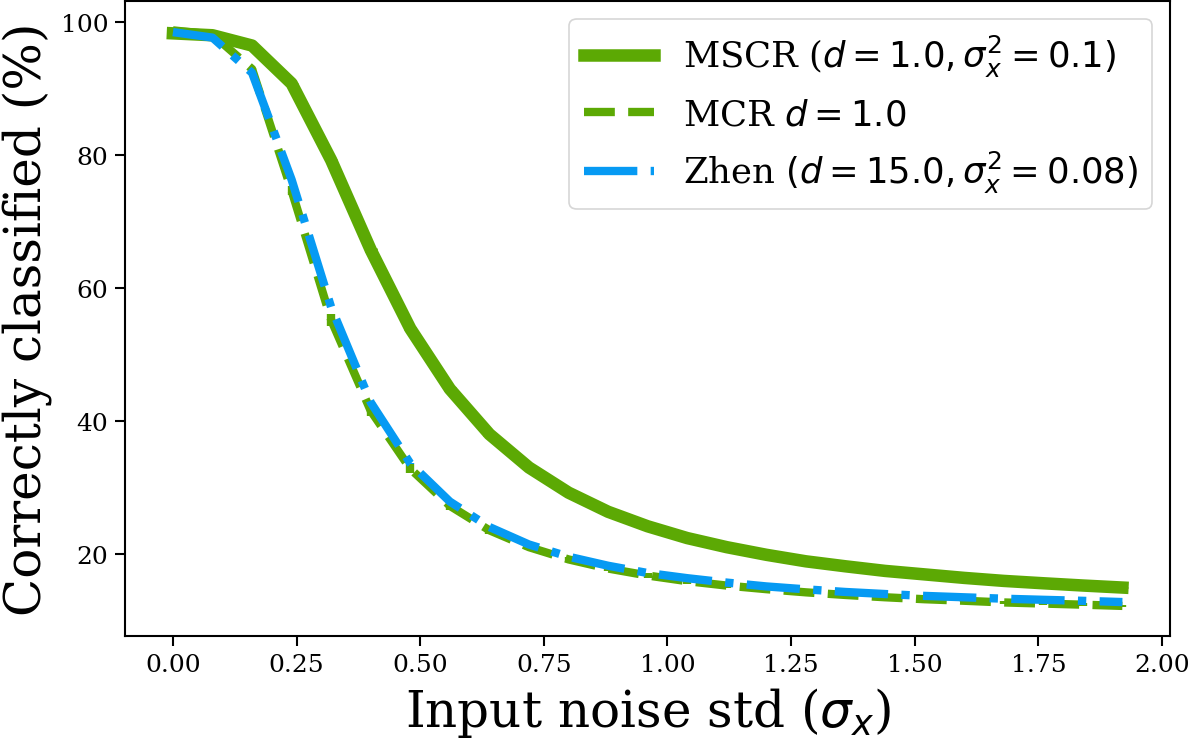

In [ ]:
"""# PLOTS PERFORMANCE COMPARISON

## 98.5 +- 0.3 ACCURACY
"""

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Certified radius (Margin)', fontsize=24)
ax.set_ylabel('Safe samples (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 25
x_axis = np.arange(500) * 0.08
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_1.0']['lip'][:,:x_range],axis = 0),100*np.std(results['mscr_1.0']['lip'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_1.0']['lip'][:,:x_range],axis = 0),100*np.std(results['mcr_1.0']['lip'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 4)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['lip'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['lip'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=1.0,\sigma_x^2=0.1)$","MCR $d=1.0$", "Zhen $(d=15.0,\sigma_x^2=0.08)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0985_lip_cr.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Certified radius (RS)', fontsize=24)
ax.set_ylabel('Safe samples (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 17
x_axis = np.arange(500) * 0.08
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_1.0']['rs'][:,:x_range],axis = 0),100*np.std(results['mscr_1.0']['rs'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_1.0']['rs'][:,:x_range],axis = 0),100*np.std(results['mcr_1.0']['rs'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 4)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['rs'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['rs'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=1.0,\sigma_x^2=0.1)$","MCR $d=1.0$", "Zhen $(d=15.0,\sigma_x^2=0.08)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0985_rs_cr.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Linear corruption SSNR', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.axhline(y=50, color='black', linestyle='--', linewidth = 1.00, dashes=(6, 9))
ax.axvline(x=0.25, color='black', linestyle='--', linewidth = 1.00, dashes=(6, 9))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 21
x_axis = 1 - np.arange(21) * 0.05
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_1.0']['ssnr'][:,:x_range],axis = 0),100*np.std(results['mscr_1.0']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_1.0']['ssnr'][:,:x_range],axis = 0),100*np.std(results['mcr_1.0']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 4)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['ssnr'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=1.0,\sigma_x^2=0.1)$","MCR $d=1.0$", "Zhen $(d=15.0,\sigma_x^2=0.08)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0985_ssnr.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Input noise std ($\sigma_x$)', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 25
x_axis = np.arange(500) * 0.08
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_1.0']['gn'][:,:x_range],axis = 0),100*np.std(results['mscr_1.0']['gn'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_1.0']['gn'][:,:x_range],axis = 0),100*np.std(results['mcr_1.0']['gn'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 4)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['gn'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['gn'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=1.0,\sigma_x^2=0.1)$","MCR $d=1.0$", "Zhen $(d=15.0,\sigma_x^2=0.08)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0985_noise_acc.png', bbox_inches='tight', dpi = 600)
plt.show()


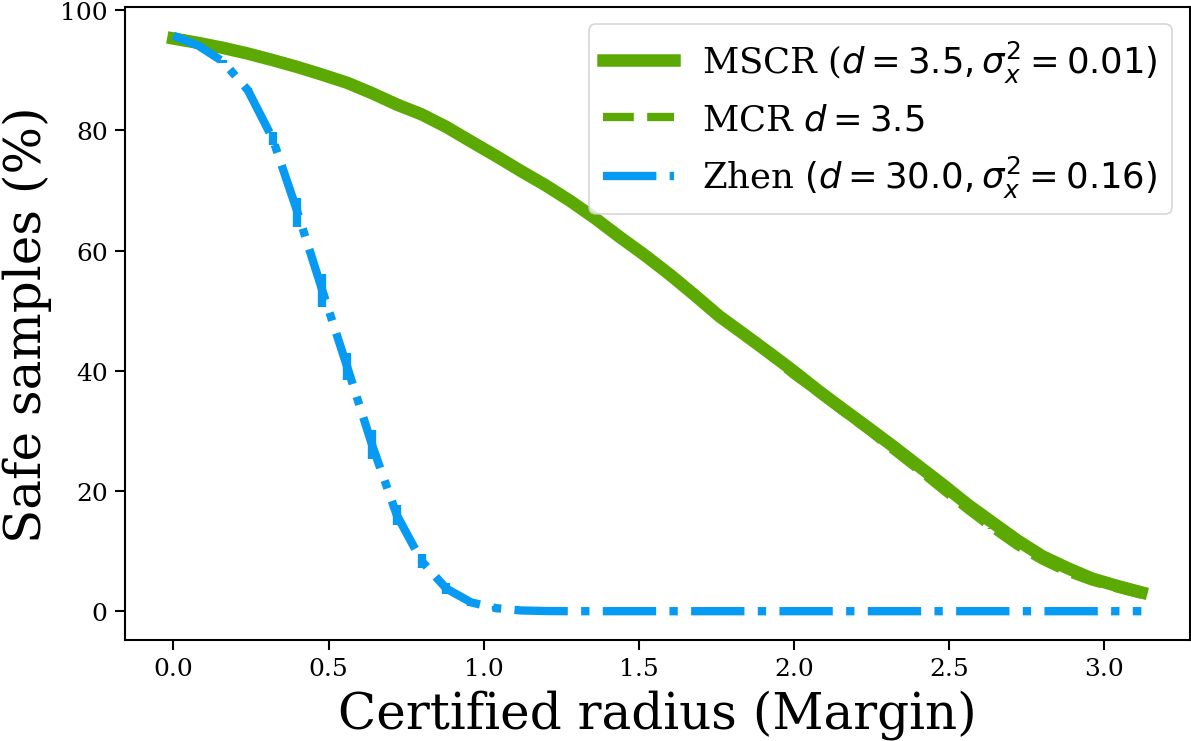

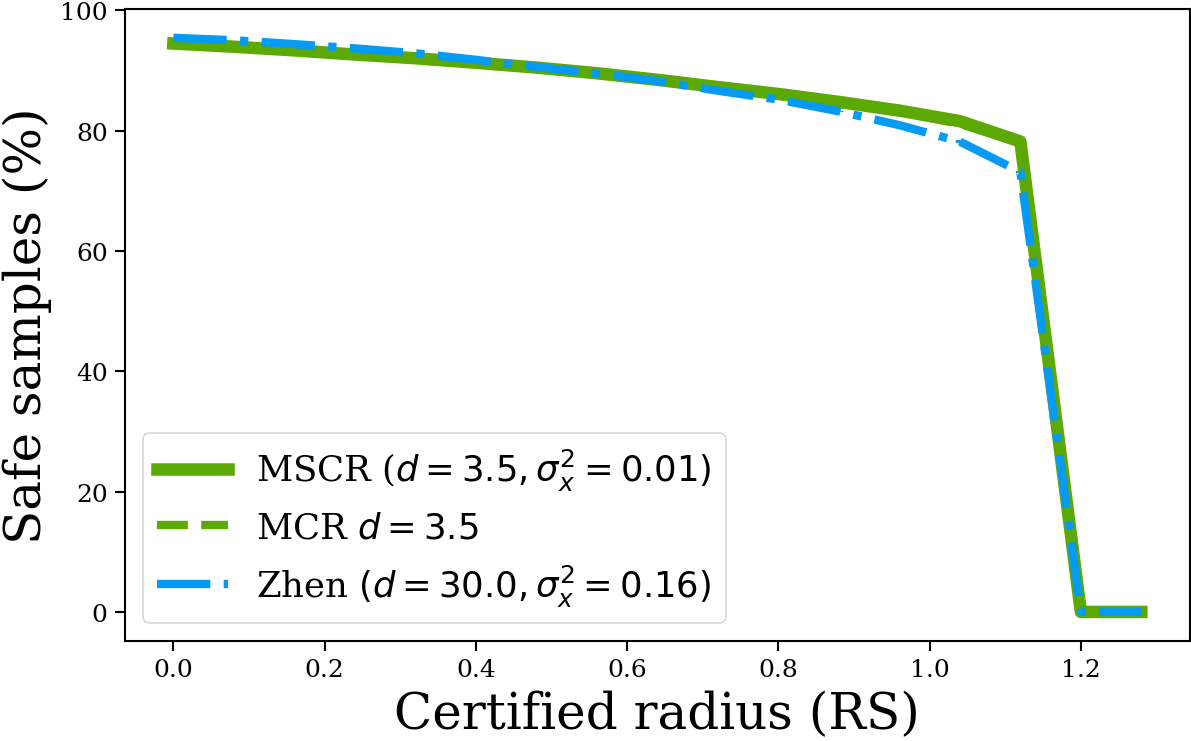

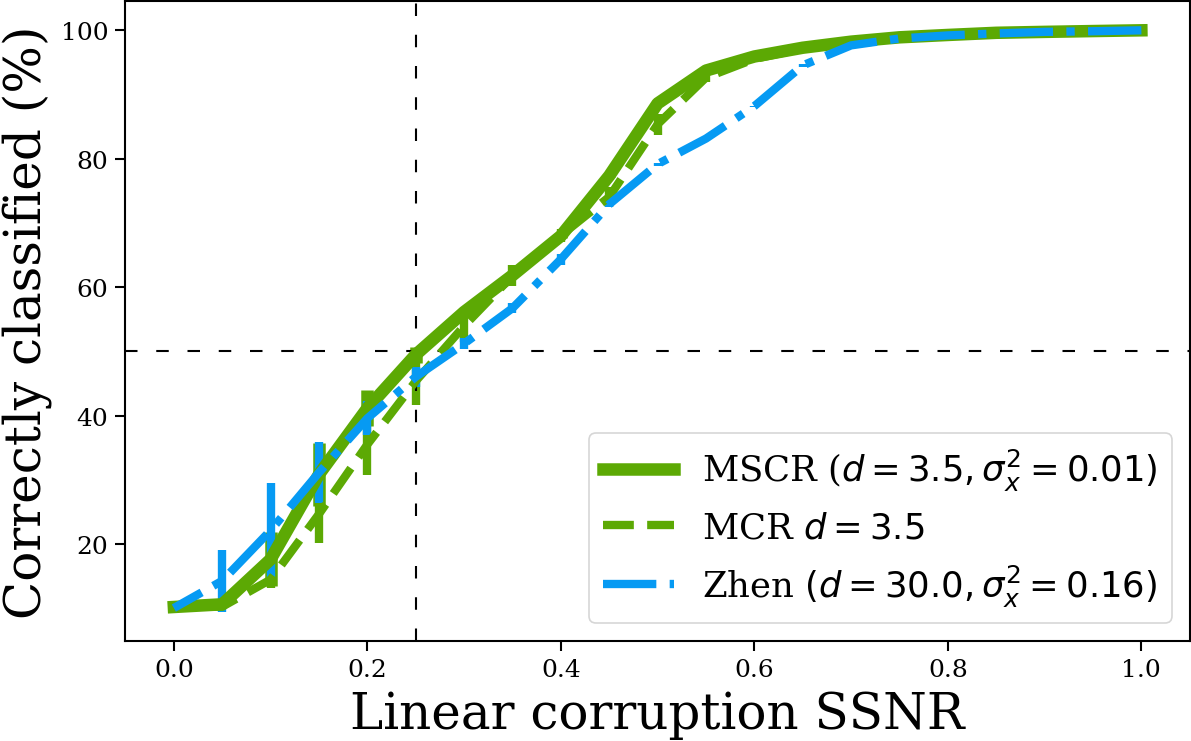

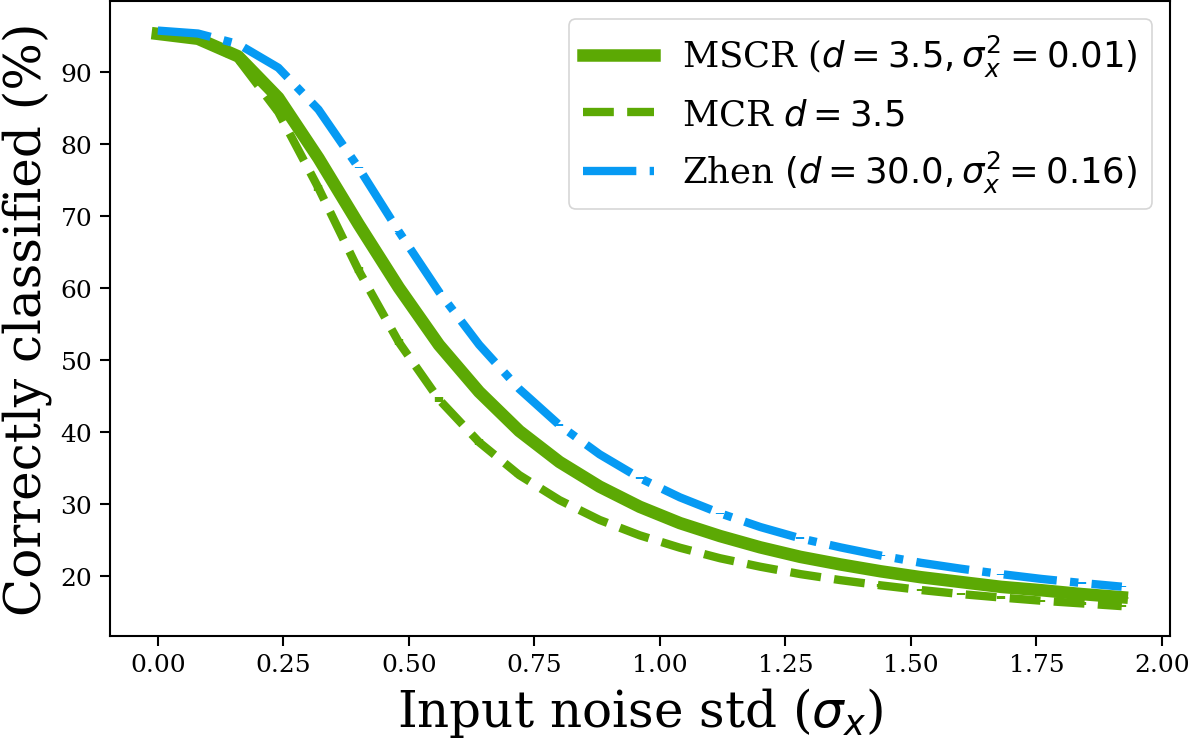

In [9]:
"""## 95.5 +- 0.3 ACCURACY"""

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Certified radius (Margin)', fontsize=24)
ax.set_ylabel('Safe samples (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 40
x_axis = np.arange(500) * 0.08
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_3.5']['lip'][:,:x_range],axis = 0),100*np.std(results['mscr_3.5']['lip'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_3.5']['lip'][:,:x_range],axis = 0),100*np.std(results['mcr_3.5']['lip'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 4)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['lip'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['lip'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=3.5,\sigma_x^2=0.01)$","MCR $d=3.5$", "Zhen $(d=30.0,\sigma_x^2=0.16)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0955_lip_cr.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Certified radius (RS)', fontsize=24)
ax.set_ylabel('Safe samples (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 17
x_axis = np.arange(500) * 0.08
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_3.5']['rs'][:,:x_range],axis = 0),100*np.std(results['mscr_3.5']['rs'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_3.5']['rs'][:,:x_range],axis = 0),100*np.std(results['mcr_3.5']['rs'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 4)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['rs'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['rs'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=3.5,\sigma_x^2=0.01)$","MCR $d=3.5$", "Zhen $(d=30.0,\sigma_x^2=0.16)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0955_rs_cr.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Linear corruption SSNR', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.axhline(y=50, color='black', linestyle='--', linewidth = 1.00, dashes=(6, 9))
ax.axvline(x=0.25, color='black', linestyle='--', linewidth = 1.00, dashes=(6, 9))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 21
x_axis = 1 - np.arange(21) * 0.05
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_3.5']['ssnr'][:,:x_range],axis = 0),100*np.std(results['mscr_3.5']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_3.5']['ssnr'][:,:x_range],axis = 0),100*np.std(results['mcr_3.5']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 4)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['ssnr'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=3.5,\sigma_x^2=0.01)$","MCR $d=3.5$", "Zhen $(d=30.0,\sigma_x^2=0.16)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0955_ssnr.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Input noise std ($\sigma_x$)', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 25
x_axis = np.arange(500) * 0.08
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_3.5']['gn'][:,:x_range],axis = 0),100*np.std(results['mscr_3.5']['gn'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_3.5']['gn'][:,:x_range],axis = 0),100*np.std(results['mcr_3.5']['gn'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 4)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['gn'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['gn'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=3.5,\sigma_x^2=0.01)$","MCR $d=3.5$", "Zhen $(d=30.0,\sigma_x^2=0.16)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0955_noise_accXstd.png', bbox_inches='tight', dpi = 600)
plt.show()

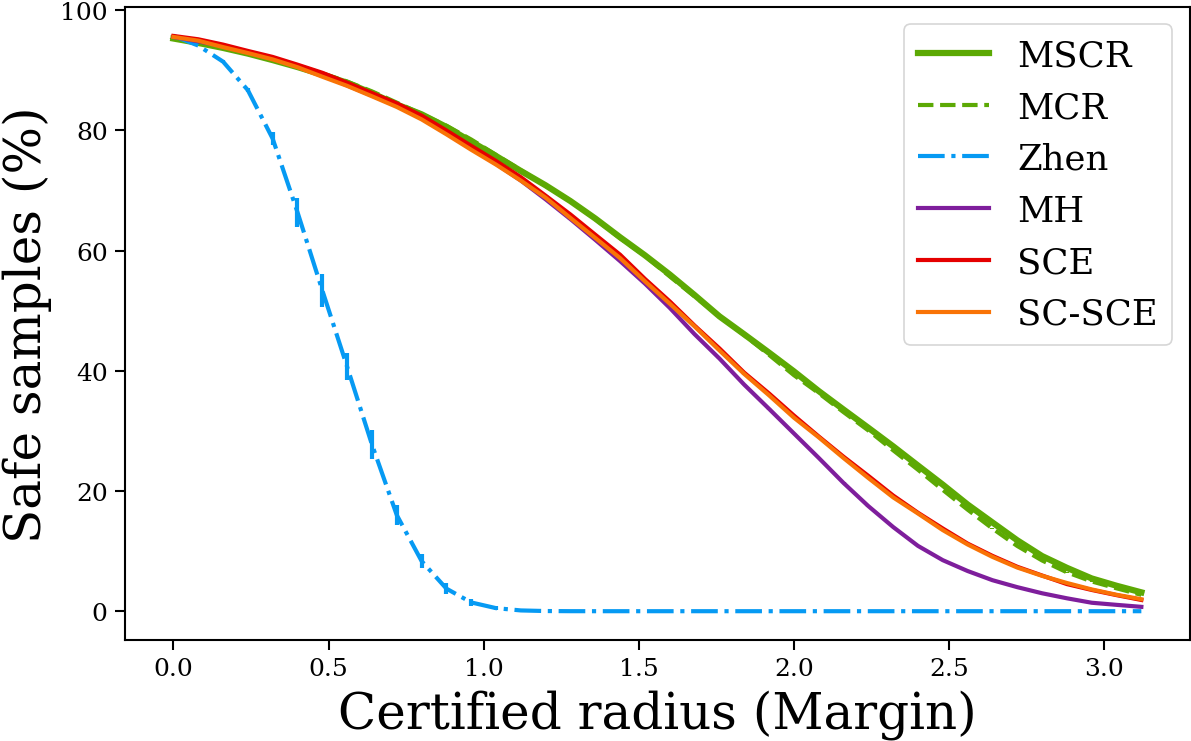

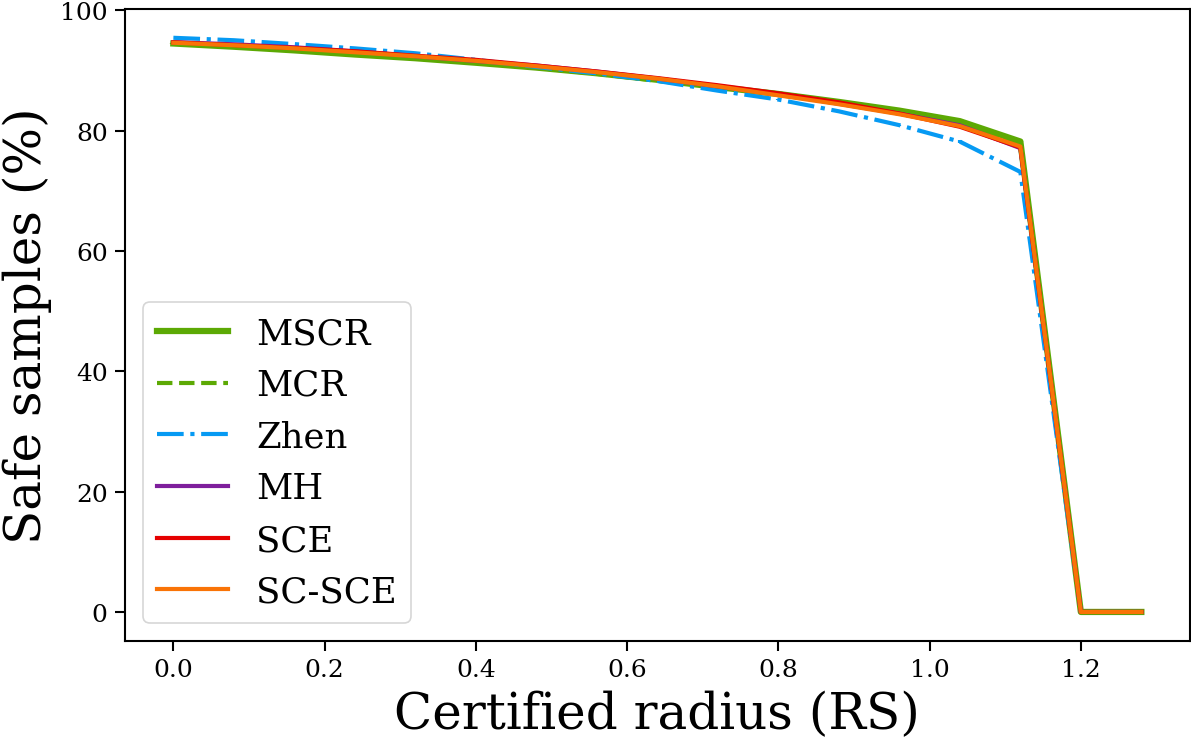

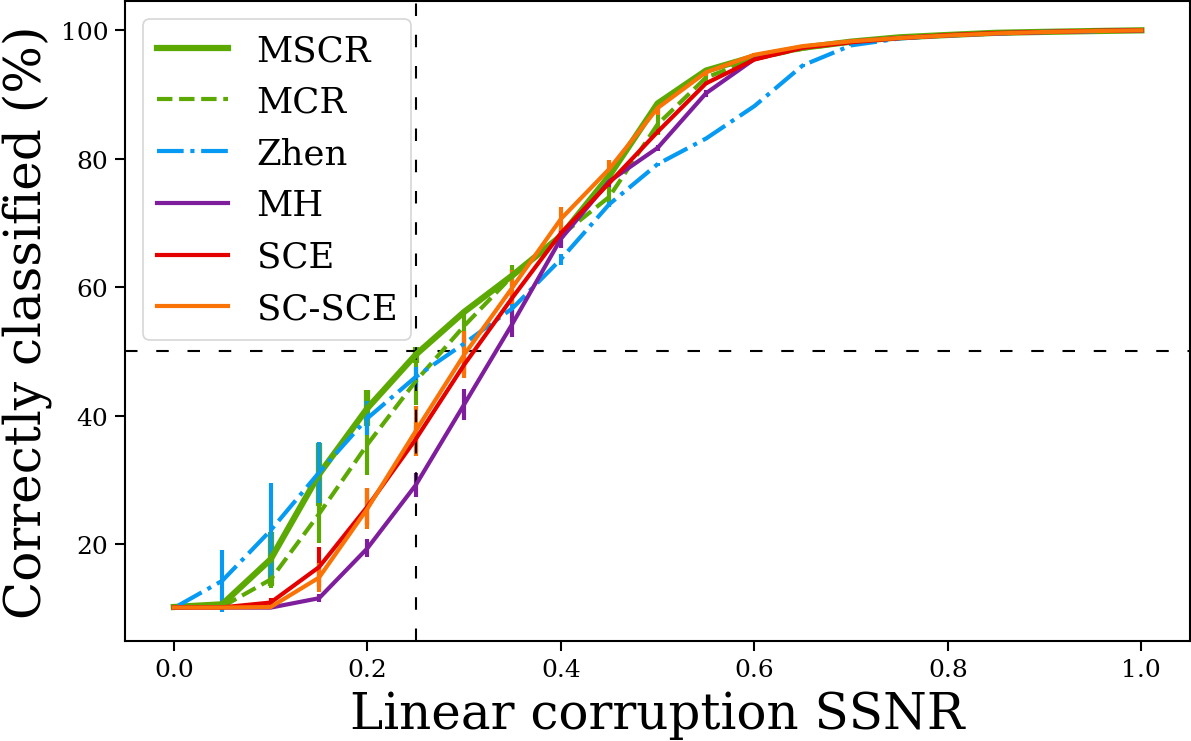

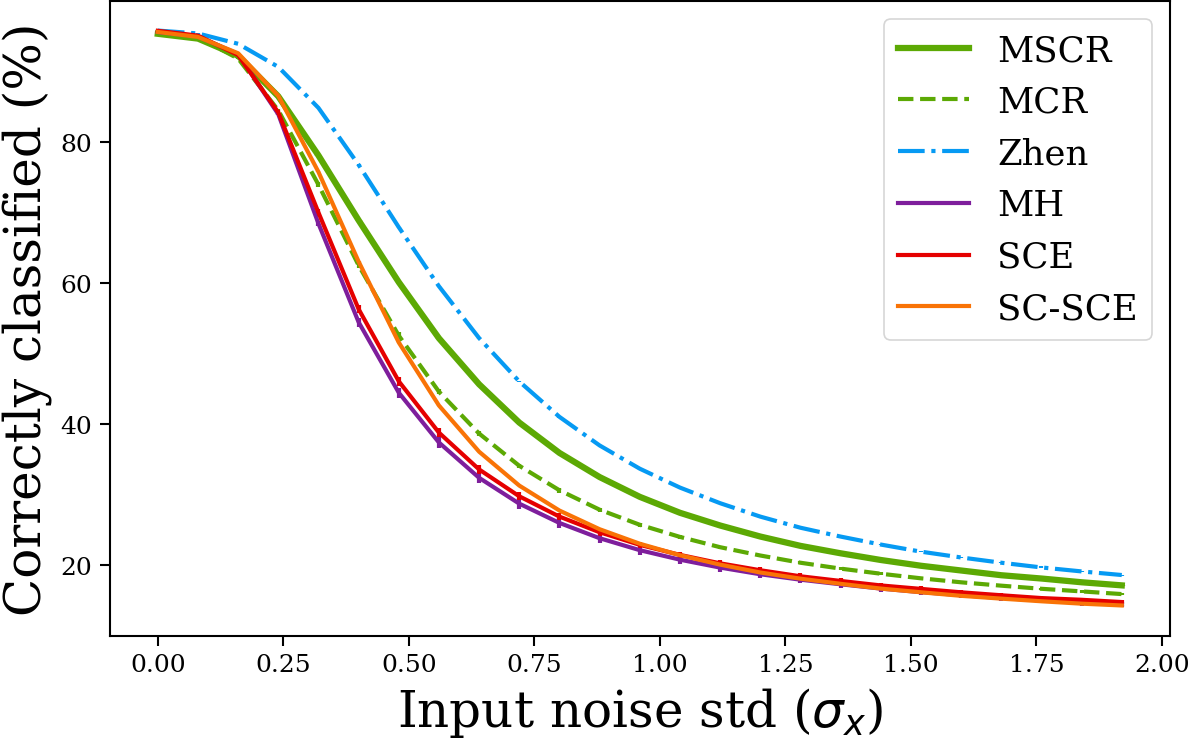

In [10]:
"""## 95.5 +- 0.3 ACCURACY - ALL LOSSES"""

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Certified radius (Margin)', fontsize=24)
ax.set_ylabel('Safe samples (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 40
x_axis = np.arange(500) * 0.08
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_3.5']['lip'][:,:x_range],axis = 0),100*np.std(results['mscr_3.5']['lip'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 3)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_3.5']['lip'][:,:x_range],axis = 0),100*np.std(results['mcr_3.5']['lip'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 2)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['lip'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['lip'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 2)
line4 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mc_hinge_3.0']['lip'][:,:x_range],axis = 0),100*np.std(results['mc_hinge_3.0']['lip'][:,:x_range],axis = 0),  color = 'xkcd:purple', linestyle = "-", linewidth = 2)
line5 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['sce_0.0']['lip'][:,:x_range],axis = 0),100*np.std(results['sce_0.0']['lip'][:,:x_range],axis = 0),  color = 'xkcd:red', linestyle = "-", linewidth = 2)
line6 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['scsce_0.0']['lip'][:,:x_range],axis = 0),100*np.std(results['scsce_0.0']['lip'][:,:x_range],axis = 0),  color = 'xkcd:orange', linestyle = "-", linewidth = 2)
legend = ax.legend((line1[0], line2[0], line3[0],line4[0], line5[0], line6[0]), ("MSCR", "MCR", "Zhen", "MH", "SCE",  "SC-SCE"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_all_0955_lip_cr.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Certified radius (RS)', fontsize=24)
ax.set_ylabel('Safe samples (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 17
x_axis = np.arange(500) * 0.08
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_3.5']['rs'][:,:x_range],axis = 0),100*np.std(results['mscr_3.5']['rs'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 3)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_3.5']['rs'][:,:x_range],axis = 0),100*np.std(results['mcr_3.5']['rs'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 2)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['rs'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['rs'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 2)
line4 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mc_hinge_3.0']['rs'][:,:x_range],axis = 0),100*np.std(results['mc_hinge_3.0']['rs'][:,:x_range],axis = 0),  color = 'xkcd:purple', linestyle = "-", linewidth = 2)
line5 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['sce_0.0']['rs'][:,:x_range],axis = 0),100*np.std(results['sce_0.0']['rs'][:,:x_range],axis = 0),  color = 'xkcd:red', linestyle = "-", linewidth = 2)
line6 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['scsce_0.0']['rs'][:,:x_range],axis = 0),100*np.std(results['scsce_0.0']['rs'][:,:x_range],axis = 0),  color = 'xkcd:orange', linestyle = "-", linewidth = 2)
legend = ax.legend((line1[0], line2[0], line3[0],line4[0], line5[0], line6[0]), ("MSCR", "MCR", "Zhen", "MH", "SCE",  "SC-SCE"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_all_0955_rs_cr.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Linear corruption SSNR', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.axhline(y=50, color='black', linestyle='--', linewidth = 1.00, dashes=(6, 9))
ax.axvline(x=0.25, color='black', linestyle='--', linewidth = 1.00, dashes=(6, 9))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 21
x_axis = 1 - np.arange(21) * 0.05
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_3.5']['ssnr'][:,:x_range],axis = 0),100*np.std(results['mscr_3.5']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 3)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_3.5']['ssnr'][:,:x_range],axis = 0),100*np.std(results['mcr_3.5']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 2)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['ssnr'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 2)
line4 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mc_hinge_3.0']['ssnr'][:,:x_range],axis = 0),100*np.std(results['mc_hinge_3.0']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:purple', linestyle = "-", linewidth = 2)
line5 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['sce_0.0']['ssnr'][:,:x_range],axis = 0),100*np.std(results['sce_0.0']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:red', linestyle = "-", linewidth = 2)
line6 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['scsce_0.0']['ssnr'][:,:x_range],axis = 0),100*np.std(results['scsce_0.0']['ssnr'][:,:x_range],axis = 0),  color = 'xkcd:orange', linestyle = "-", linewidth = 2)
legend = ax.legend((line1[0], line2[0], line3[0],line4[0], line5[0], line6[0]), ("MSCR", "MCR", "Zhen", "MH", "SCE",  "SC-SCE"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_all_0955_ssnr.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Input noise std ($\sigma_x$)', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_range = 25
x_axis = np.arange(500) * 0.08
line1 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mscr_3.5']['gn'][:,:x_range],axis = 0),100*np.std(results['mscr_3.5']['gn'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 3)
line2 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mcr_3.5']['gn'][:,:x_range],axis = 0),100*np.std(results['mcr_3.5']['gn'][:,:x_range],axis = 0),  color = 'xkcd:leaf green', linestyle = "--", linewidth = 2)
line3 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['zhen_15.0']['gn'][:,:x_range],axis = 0),100*np.std(results['zhen_15.0']['gn'][:,:x_range],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 2)
line4 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['mc_hinge_3.0']['gn'][:,:x_range],axis = 0),100*np.std(results['mc_hinge_3.0']['gn'][:,:x_range],axis = 0),  color = 'xkcd:purple', linestyle = "-", linewidth = 2)
line5 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['sce_0.0']['gn'][:,:x_range],axis = 0),100*np.std(results['sce_0.0']['gn'][:,:x_range],axis = 0),  color = 'xkcd:red', linestyle = "-", linewidth = 2)
line6 = ax.errorbar(x_axis[:x_range], 100*np.mean(results['scsce_0.0']['gn'][:,:x_range],axis = 0),100*np.std(results['scsce_0.0']['gn'][:,:x_range],axis = 0),  color = 'xkcd:orange', linestyle = "-", linewidth = 2)
legend = ax.legend((line1[0], line2[0], line3[0],line4[0], line5[0], line6[0]), ("MSCR", "MCR", "Zhen", "MH", "SCE",  "SC-SCE"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_all_0955_noise_accXstd.png', bbox_inches='tight', dpi = 600)
plt.show()

In [ ]:
"""## 95.5 +- 0.3 ACCURACY - ALL LOSSES"""

mscr_SSNR_acc_np
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Maximal $\ell_2$ radius of attack', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.set_xlim(left = -0.1, right = 6.1)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_axis = np.arange(mcr_l2_acc_np.shape[2]) * 0.32
d_idx = 6
line1 = ax.errorbar(x_axis, 100*np.mean(mcr_clean_acc_np[d_idx,:].reshape((3,1))*mcr_l2_acc_np[d_idx,:,:],axis = 0),100*np.std(mcr_clean_acc_np[d_idx,:].reshape((3,1))*mcr_l2_acc_np[d_idx,:,:],axis = 0),  color = 'xkcd:leaf green', linestyle = ":", linewidth = 2)
x_axis = np.arange(mscr_l2_acc_np.shape[3]) * 0.32
d_idx = 6; x_var_idx = 5
line2 = ax.errorbar(x_axis, 100*np.mean(mscr_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*mscr_l2_acc_np[x_var_idx,d_idx,:,:],axis = 0),100*np.std(mscr_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*mscr_l2_acc_np[x_var_idx,d_idx,:,:],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 3)
x_axis = np.arange(zhen_l2_acc_np.shape[3]) * 0.32
d_idx = 5; x_var_idx = 4
line3 = ax.errorbar(x_axis, 100*np.mean(zhen_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*zhen_l2_acc_np[x_var_idx,d_idx,:,:],axis = 0),100*np.std(zhen_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*zhen_l2_acc_np[x_var_idx,d_idx,:,:],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 2)
x_axis = np.arange(mh_l2_acc_np.shape[2]) * 0.32
line4 = ax.errorbar(x_axis, 100*np.mean(mh_clean_acc_np[5,:].reshape((3,1))*mh_l2_acc_np[5,:,:],axis = 0),100*np.std(mh_clean_acc_np[5,:].reshape((3,1))*mh_l2_acc_np[5,:,:],axis = 0),  color = 'xkcd:purple', linestyle = "-", linewidth = 2)
x_axis = np.arange(sce_l2_acc_np.shape[1]) * 0.32
line5 = ax.errorbar(x_axis, 100*np.mean(sce_clean_acc_np.reshape((3,1))*sce_l2_acc_np,axis = 0),100*np.std(sce_clean_acc_np.reshape((3,1))*sce_l2_acc_np,axis = 0),  color = 'xkcd:red', linestyle = "-", linewidth = 2)
x_axis = np.arange(scsce_l2_acc_np.shape[2]) * 0.32
idx = 2
line6 = ax.errorbar(x_axis, 100*np.mean(scsce_clean_acc_np[idx,:].reshape((3,1))*scsce_l2_acc_np[idx,:,:],axis = 0),100*np.std(scsce_clean_acc_np[idx,:].reshape((3,1))*scsce_l2_acc_np[idx,:,:],axis = 0),  color = 'xkcd:orange', linestyle = "-", linewidth = 2)
legend = ax.legend((line1[0], line2[0], line3[0], line4[0],line5[0], line6[0]), ("MCR", "MSCR","Zhen", "MH", "SCE",  "SC-SCE"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
# plt.savefig(PARENT_DIR + '/Paper_plots/_best_0955_all_adv_accXL2_radius.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Maximal $\ell_\infty$ radius of attack', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.locator_params(axis = 'x', nbins = 5)
ax.set_xlim(left = -0.01, right = 0.41)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_axis = np.arange(mcr_linf_acc_np.shape[2]) * 0.025
d_idx = 6
line1 = ax.errorbar(x_axis, 100*np.mean(mcr_clean_acc_np[d_idx,:].reshape((3,1))*mcr_linf_acc_np[d_idx,:,:],axis = 0),100*np.std(mcr_clean_acc_np[d_idx,:].reshape((3,1))*mcr_linf_acc_np[d_idx,:,:],axis = 0),  color = 'xkcd:leaf green', linestyle = ":", linewidth = 2)
x_axis = np.arange(mscr_linf_acc_np.shape[3]) * 0.025
d_idx = 6; x_var_idx = 5
line2 = ax.errorbar(x_axis, 100*np.mean(mscr_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*mscr_linf_acc_np[x_var_idx,d_idx,:,:],axis = 0),100*np.std(mscr_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*mscr_linf_acc_np[x_var_idx,d_idx,:,:],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 3)
x_axis = np.arange(zhen_linf_acc_np.shape[3]) * 0.025
d_idx = 5; x_var_idx = 4
line3 = ax.errorbar(x_axis, 100*np.mean(zhen_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*zhen_linf_acc_np[x_var_idx,d_idx,:,:],axis = 0),100*np.std(zhen_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*zhen_linf_acc_np[x_var_idx,d_idx,:,:],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 2)
x_axis = np.arange(mh_linf_acc_np.shape[2]) * 0.025
line4 = ax.errorbar(x_axis, 100*np.mean(mh_clean_acc_np[5,:].reshape((3,1))*mh_linf_acc_np[5,:,:],axis = 0),100*np.std(mh_clean_acc_np[5,:].reshape((3,1))*mh_linf_acc_np[5,:,:],axis = 0),  color = 'xkcd:purple', linestyle = "-", linewidth = 2)
x_axis = np.arange(sce_linf_acc_np.shape[1]) * 0.025
line5 = ax.errorbar(x_axis, 100*np.mean(sce_clean_acc_np.reshape((3,1))*sce_linf_acc_np,axis = 0),100*np.std(sce_clean_acc_np.reshape((3,1))*sce_linf_acc_np,axis = 0),  color = 'xkcd:red', linestyle = "-", linewidth = 2)
x_axis = np.arange(scsce_linf_acc_np.shape[2]) * 0.025
idx = 2
line6 = ax.errorbar(x_axis, 100*np.mean(scsce_clean_acc_np[idx,:].reshape((3,1))*scsce_linf_acc_np[idx,:,:],axis = 0),100*np.std(scsce_clean_acc_np[idx,:].reshape((3,1))*scsce_linf_acc_np[idx,:,:],axis = 0),  color = 'xkcd:orange', linestyle = "-", linewidth = 2)
legend = ax.legend((line1[0], line2[0], line3[0], line4[0],line5[0], line6[0]), ("MCR", "MSCR","Zhen", "MH", "SCE",  "SC-SCE"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
# plt.savefig(PARENT_DIR + '/Paper_plots/_best_0955_all_adv_accXLinf_radius.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Input noise std ($\sigma_x$)', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.set_xlim(left = -0.1, right = 6.1)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_axis = np.arange(mcr_noise_acc_np.shape[2]) * 0.32
d_idx = 6
line1 = ax.errorbar(x_axis, 100*np.mean(mcr_clean_acc_np[d_idx,:].reshape((3,1))*mcr_noise_acc_np[d_idx,:,:],axis = 0),100*np.std(mcr_clean_acc_np[d_idx,:].reshape((3,1))*mcr_noise_acc_np[d_idx,:,:],axis = 0),  color = 'xkcd:leaf green', linestyle = ":", linewidth = 2)
x_axis = np.arange(mscr_noise_acc_np.shape[3]) * 0.32
d_idx = 6; x_var_idx = 5
line2 = ax.errorbar(x_axis, 100*np.mean(mscr_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*mscr_noise_acc_np[x_var_idx,d_idx,:,:],axis = 0),100*np.std(mscr_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*mscr_noise_acc_np[x_var_idx,d_idx,:,:],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 3)
x_axis = np.arange(zhen_noise_acc_np.shape[3]) * 0.32
d_idx = 5; x_var_idx = 4
line3 = ax.errorbar(x_axis, 100*np.mean(zhen_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*zhen_noise_acc_np[x_var_idx,d_idx,:,:],axis = 0),100*np.std(zhen_clean_acc_np[x_var_idx,d_idx,:].reshape((3,1))*zhen_noise_acc_np[x_var_idx,d_idx,:,:],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 2)
x_axis = np.arange(mh_noise_acc_np.shape[2]) * 0.32
line4 = ax.errorbar(x_axis, 100*np.mean(mh_clean_acc_np[5,:].reshape((3,1))*mh_noise_acc_np[5,:,:],axis = 0),100*np.std(mh_clean_acc_np[5,:].reshape((3,1))*mh_noise_acc_np[5,:,:],axis = 0),  color = 'xkcd:purple', linestyle = "-", linewidth = 2)
x_axis = np.arange(sce_noise_acc_np.shape[1]) * 0.32
line5 = ax.errorbar(x_axis, 100*np.mean(sce_clean_acc_np.reshape((3,1))*sce_noise_acc_np,axis = 0),100*np.std(sce_clean_acc_np.reshape((3,1))*sce_noise_acc_np,axis = 0),  color = 'xkcd:red', linestyle = "-", linewidth = 2)
x_axis = np.arange(scsce_noise_acc_np.shape[2]) * 0.32
idx = 2
line6 = ax.errorbar(x_axis, 100*np.mean(scsce_clean_acc_np[idx,:].reshape((3,1))*scsce_noise_acc_np[idx,:,:],axis = 0),100*np.std(scsce_clean_acc_np[idx,:].reshape((3,1))*scsce_noise_acc_np[idx,:,:],axis = 0),  color = 'xkcd:orange', linestyle = "-", linewidth = 2)
legend = ax.legend((line1[0], line2[0], line3[0], line4[0],line5[0], line6[0]), ("MCR", "MSCR","Zhen", "MH", "SCE",  "SC-SCE"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
# plt.savefig(PARENT_DIR + '/Paper_plots/_best_0955_all_noise_accXnoise_std.png', bbox_inches='tight', dpi = 600)
plt.show()

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Linear corruption SSNR', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.axhline(y=50, color='black', linestyle='--', linewidth = 1.00, dashes=(6, 9))
ax.axvline(x=0.25, color='black', linestyle='--', linewidth = 1.00, dashes=(6, 9))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_axis = 1 - np.arange(mscr_SSNR_acc_np.shape[3]) * 0.05
z1 = mscr_stats[0][1:9,:]
d_idx = 6; x_var_idx = 0# clean acc 95.5 +- 0.3; max Linf rob
line1 = ax.errorbar(x_axis, 100*np.mean(mscr_SSNR_acc_np[x_var_idx,d_idx,:,:],axis = 0),100*np.std(mscr_SSNR_acc_np[x_var_idx,d_idx,:,:],axis = 0),  color = 'xkcd:leaf green', linestyle = ":", linewidth = 1)
d_idx = 6; x_var_idx = 5 # clean acc 95.5 +- 0.3; max Linf rob
line2 = ax.errorbar(x_axis, 100*np.mean(mscr_SSNR_acc_np[x_var_idx,d_idx,:,:],axis = 0),100*np.std(mscr_SSNR_acc_np[x_var_idx,d_idx,:,:],axis = 0),  color = 'xkcd:leaf green', linestyle = "-", linewidth = 3)
x_axis = 1 - np.arange(zhen_SSNR_acc_np.shape[3]) * 0.05
z1 = zhen_stats[0]
d_idx = 5; x_var_idx = 4 # clean acc 95.5 +- 0.3; max Linf rob
line3 = ax.errorbar(x_axis, 100*np.mean(zhen_SSNR_acc_np[x_var_idx,d_idx,:,:],axis = 0),100*np.std(zhen_SSNR_acc_np[x_var_idx,d_idx,:,:],axis = 0),  color = 'xkcd:azure', linestyle = "-.", linewidth = 2)
x_axis = 1 - np.arange(mh_SSNR_acc_np.shape[2]) * 0.05
line4 = ax.errorbar(x_axis, 100*np.mean(mh_SSNR_acc_np[5,:,:],axis = 0),100*np.std(mh_SSNR_acc_np[5,:,:],axis = 0),  color = 'xkcd:purple', linestyle = "-", linewidth = 2)
x_axis = 1 - np.arange(sce_SSNR_acc_np.shape[1]) * 0.05
line5 = ax.errorbar(x_axis, 100*np.mean(sce_SSNR_acc_np,axis = 0),100*np.std(sce_SSNR_acc_np,axis = 0),  color = 'xkcd:red', linestyle = "-", linewidth = 2)
x_axis = 1 - np.arange(scsce_SSNR_acc_np.shape[2]) * 0.05
idx = 2
line6 = ax.errorbar(x_axis, 100*np.mean(scsce_SSNR_acc_np[idx,:,:],axis = 0),100*np.std(scsce_SSNR_acc_np[idx,:,:],axis = 0),  color = 'xkcd:orange', linestyle = "-", linewidth = 2)
legend = ax.legend((line1[0], line2[0], line3[0], line4[0],line5[0], line6[0]), ("MCR", "MSCR","Zhen", "MH", "SCE",  "SC-SCE"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
# plt.savefig(PARENT_DIR + '/Paper_plots/_best_0955_all_corrupt_accXSSNR.png', bbox_inches='tight', dpi = 600)
plt.show()

In [60]:
gn_arr[0]

array([[1.8756, 1.5892, 1.0048, 0.6355, 0.4569, 0.3887, 0.3662],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]])

In [66]:
dir = PARENT_DIR + "/data_conv"
arg_arr = [['mscr', '1.0', '0.001'],['mcr', '1.0', '0.0'],['zhen', '4.0', '0.0001']]

clean_arr = []
lip_arr = []
rs_arr = []
gn_arr = []
ssnr_arr = []
max_lip = 0
max_rs = 0
max_gn = 0
max_ssnr = 0
max
dir = PARENT_DIR + "/data_conv/"
for arg in arg_arr:
    lip = np.zeros((3,75)).astype(dtype='float64')
    rs = np.zeros((3,16)).astype(dtype='float64')
    gn = np.zeros((3,1)).astype(dtype='float64')
    ssnr = np.zeros((3,21)).astype(dtype='float64')
    for i in range(1,4):
        # file = dir + 'loss_{}_ep_300_x_var_{}_d_{}_{}_clean_acc.npy'.format(arg[0],arg[2],arg[1],i)
        # load_file = np.load(file).reshape((1,-1))
        # zhen_clean = np.load(file).reshape((1,-1))
        
        file = dir + 'loss_{}_ep_300_x_var_{}_d_{}_{}_lip_cr.npy'.format(arg[0],arg[2],arg[1],i)
        load_file = np.load(file)
        lip_acc = []
        for radius in np.arange(0, 1.5, 0.02):
            lip_acc.append(load_file[load_file > radius].shape[0])
        load_file = np.asarray(lip_acc)/10000        
        # max_lip = np.maximum(max_lip,load_file.shape[1])
        # load_file = np.pad(load_file, ((0,0),(0, max_lip - load_file.shape[1])), 'minimum')
        # lip = np.pad(lip, ((0,0),(0, max_lip - lip.shape[1])), 'minimum')
        lip[i-1,:] += load_file
              
        file = dir + 'loss_{}_ep_300_x_var_{}_d_{}_{}_rs_cr.npy'.format(arg[0],arg[2],arg[1],i)
        load_file = np.load(file)
        RS_acc = []
        for radius in np.arange(0, 1.056, 0.066):
            RS_acc.append(load_file[load_file > radius].shape[0])
        load_file = np.asarray(RS_acc)/10000
        # max_rs = np.maximum(max_rs,load_file.shape[1])
        # load_file = np.pad(load_file, ((0,0),(0, max_rs - load_file.shape[1])), 'minimum')
        # rs = np.pad(rs, ((0,0),(0, max_rs - rs.shape[1])), 'minimum')
        rs[i-1,:] += load_file
                     
        file = dir + 'loss_{}_ep_300_x_var_{}_d_{}_{}_gauss_acc.npy'.format(arg[0],arg[2],arg[1],i)
        load_file = np.load(file).reshape((1,-1))
        max_gn = np.maximum(max_gn,load_file.shape[1])
        load_file = np.pad(load_file, ((0,0),(0, max_gn - load_file.shape[1])), 'minimum')
        gn = np.pad(gn, ((0,0),(0, max_gn - gn.shape[1])), 'minimum')
        gn[i-1,:] += load_file[0,:]
                
        file = dir + 'loss_{}_ep_300_x_var_{}_d_{}_{}_SSNR_acc.npy'.format(arg[0],arg[2],arg[1],i)
        load_file = np.load(file).reshape((1,-1))
        # max_ssnr = np.maximum(max_ssnr,load_file.shape[1])
        # load_file = np.pad(load_file, ((0,0),(0, max_ssnr - load_file.shape[1])), 'minimum')
        # ssnr = np.pad(ssnr, ((0,0),(0, max_ssnr - ssnr.shape[1])), 'minimum')
        ssnr[i-1,:] += load_file[0,:]
        
    lip_arr.append(lip)
    rs_arr.append(rs)
    gn_arr.append(gn)
    ssnr_arr.append(ssnr)

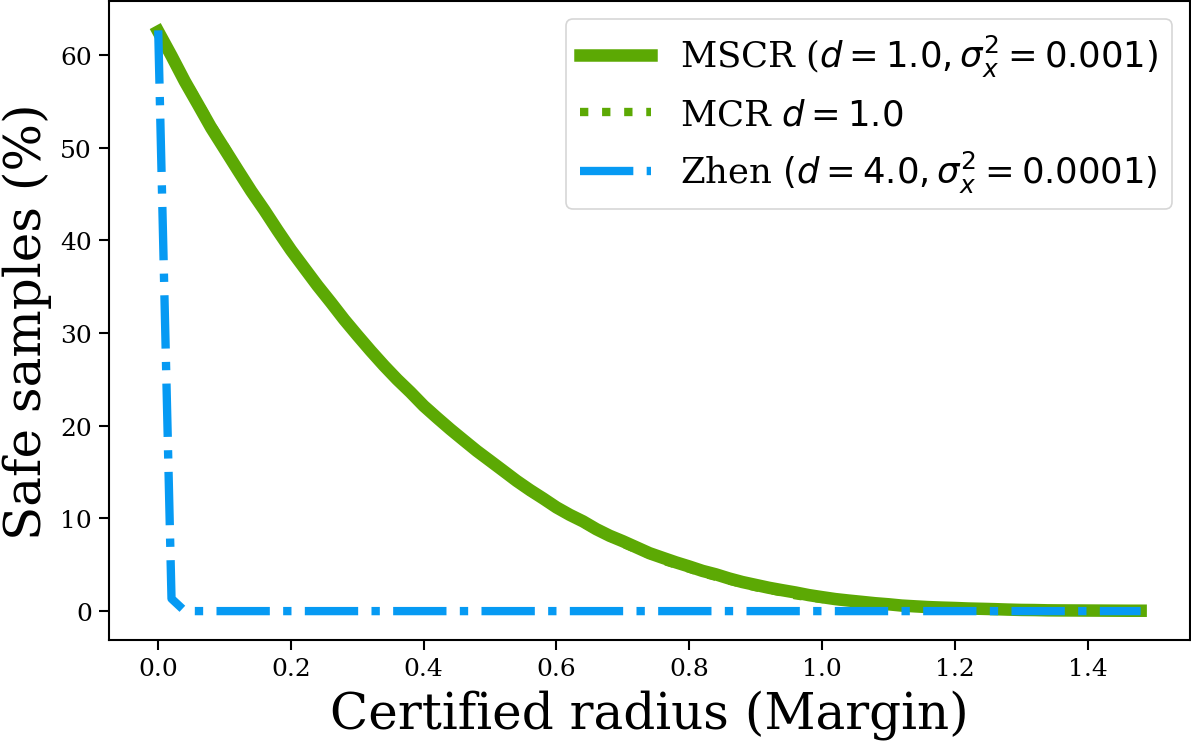

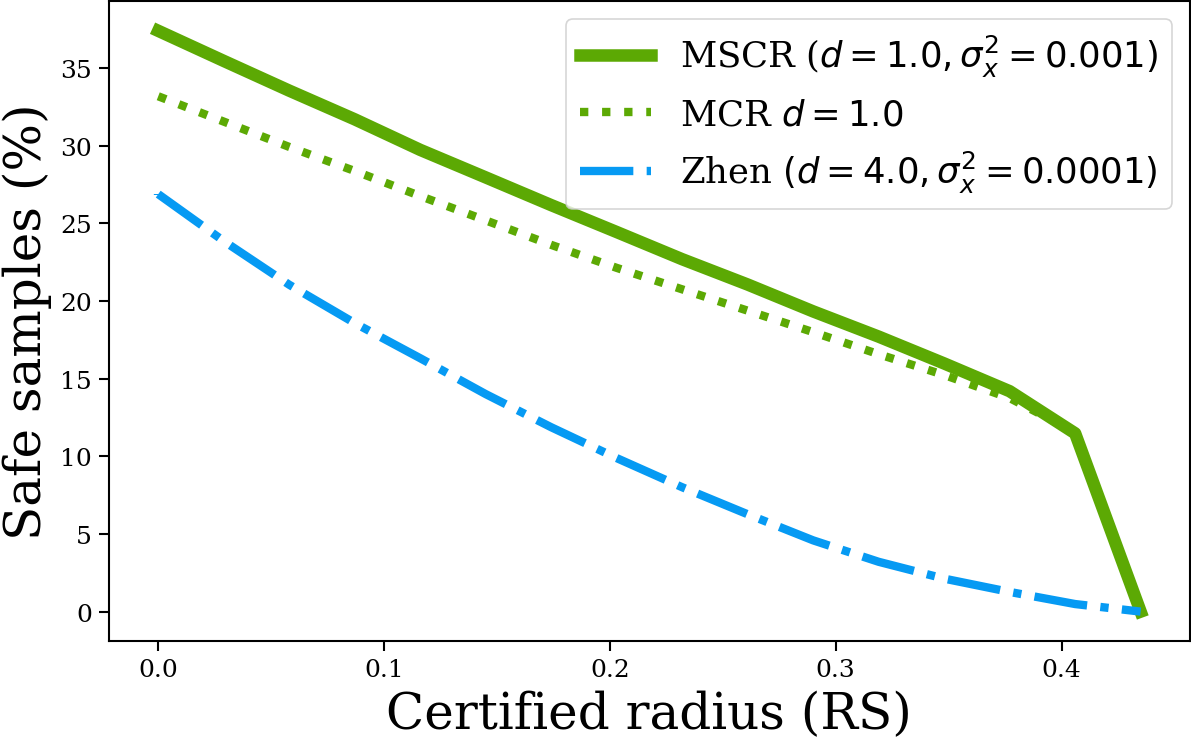

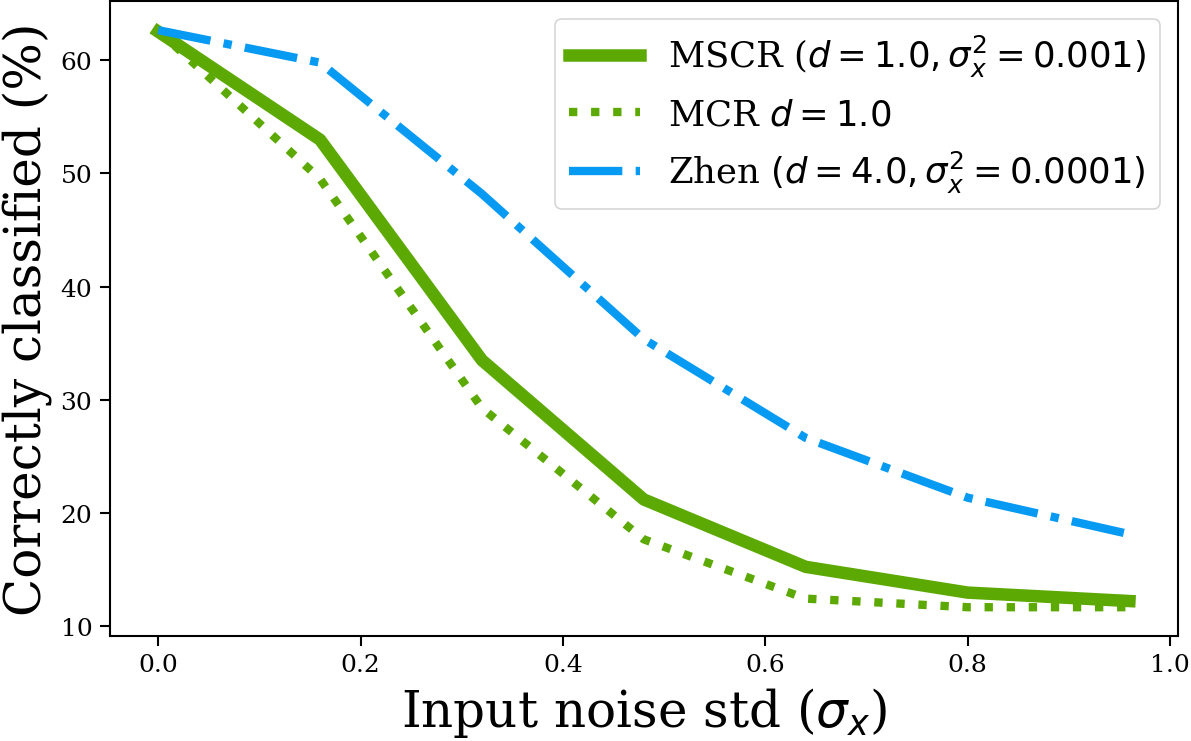

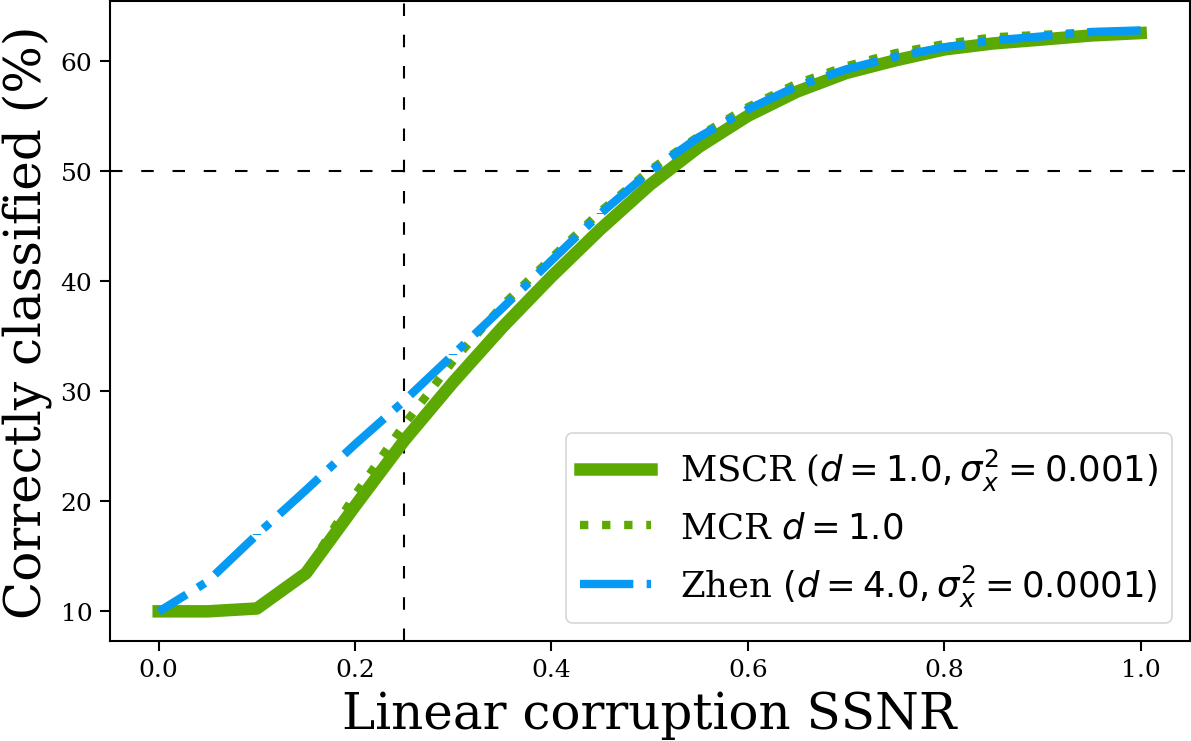

In [73]:
"""# PLOTS PERFORMANCE COMPARISON

## 62.6 +- 0.1 ACCURACY
"""
x_range = 75
lip_arr[0]
rs_arr[0]
gn_arr[0]
ssnr_arr[0]
max_range = np.max((lip_arr[0].shape[1], lip_arr[1].shape[1], lip_arr[2].shape[1]))
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Certified radius (Margin)', fontsize=24)
ax.set_ylabel('Safe samples (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_axis = np.arange(75) * 0.02
line1 = ax.errorbar(x_axis[0:x_range],100*np.mean(lip_arr[0],axis = 0)[0:x_range], np.std(lip_arr[0],axis = 0)[0:x_range], color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[0:x_range],100*np.mean(lip_arr[1],axis = 0)[0:x_range], np.std(lip_arr[1],axis = 0)[0:x_range], color = 'xkcd:leaf green', linestyle = ":", linewidth = 4)
line3 = ax.errorbar(x_axis[0:x_range],100*np.mean(lip_arr[2],axis = 0)[0:x_range], np.std(lip_arr[2],axis = 0)[0:x_range], color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
# line4 = ax.errorbar(x_axis[0:x_range],100*np.mean(dic['zhen']['4.0']['0.001']["l2"],axis = 0)[0:x_range], np.std(dic['zhen']['4.0']['0.001']["l2"],axis = 0)[0:x_range], color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
# line5 = ax.errorbar(x_axis[0:x_range],100*np.mean(dic['zhen']['4.0']['0.01']["l2"],axis = 0)[0:x_range], np.std(dic['zhen']['4.0']['0.01']["l2"],axis = 0)[0:x_range], color = 'xkcd:blue', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=1.0,\sigma_x^2=0.001)$","MCR $d=1.0$","Zhen $(d=4.0,\sigma_x^2=0.0001)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
# legend = ax.legend((line1[0], line2[0], line3[0], line4[0], line5[0]), ( "MSCR ($d=1.0,\sigma_x^2=0.001)$","MCR $d=1.0$","Zhen $(d=4.0,\sigma_x^2=0.0001)$","Zhen $(d=4.0,\sigma_x^2=0.001)$","Zhen $(d=4.0,\sigma_x^2=0.01)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0625_adv_accXlip_cr.png', bbox_inches='tight', dpi = 600)
plt.show()

x_range = 16
# max_range = np.max((dic['mscr']['1.0']['0.001']["linf"].shape[1], dic['mcr']['1.0']['0.0']["linf"].shape[1], dic['zhen']['4.0']['0.001']["linf"].shape[1]))
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Certified radius (RS)', fontsize=24)
ax.set_ylabel('Safe samples (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_axis = np.arange(x_range) * 0.029
line1 = ax.errorbar(x_axis[0:x_range],100*np.mean(rs_arr[0],axis = 0)[0:x_range], np.std(rs_arr[0],axis = 0)[0:x_range], color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[0:x_range],100*np.mean(rs_arr[1],axis = 0)[0:x_range], np.std(rs_arr[1],axis = 0)[0:x_range], color = 'xkcd:leaf green', linestyle = ":", linewidth = 4)
line3 = ax.errorbar(x_axis[0:x_range],100*np.mean(rs_arr[2],axis = 0)[0:x_range], np.std(rs_arr[2],axis = 0)[0:x_range], color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
# line4 = ax.errorbar(x_axis[0:x_range],100*np.mean(dic['zhen']['4.0']['0.001']["linf"],axis = 0)[0:x_range],np.std(100*dic['zhen']['4.0']['0.001']["linf"],axis = 0)[0:x_range], color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
# line5 = ax.errorbar(x_axis[0:x_range],100*np.mean(dic['zhen']['4.0']['0.01']["linf"],axis = 0)[0:x_range],np.std(100*dic['zhen']['4.0']['0.01']["linf"],axis = 0)[0:x_range], color = 'xkcd:blue', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=1.0,\sigma_x^2=0.001)$","MCR $d=1.0$","Zhen $(d=4.0,\sigma_x^2=0.0001)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0625_adv_accXrs_cr.png', bbox_inches='tight', dpi = 600)
plt.show()

x_range = 7
# max_range = np.max((dic['mscr']['1.0']['0.001']["gn"].shape[1], dic['mcr']['1.0']['0.0']["gn"].shape[1], dic['zhen']['4.0']['0.001']["gn"].shape[1]))
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Input noise std ($\sigma_x$)', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_axis = np.arange(x_range) * 0.16
line1 = ax.errorbar(x_axis[0:x_range],100*np.mean(gn_arr[0],axis = 0)[0:x_range], np.std(gn_arr[0],axis = 0)[0:x_range], color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[0:x_range],100*np.mean(gn_arr[1],axis = 0)[0:x_range], np.std(gn_arr[1],axis = 0)[0:x_range], color = 'xkcd:leaf green', linestyle = ":", linewidth = 4)
line3 = ax.errorbar(x_axis[0:x_range],100*np.mean(gn_arr[2],axis = 0)[0:x_range], np.std(gn_arr[2],axis = 0)[0:x_range], color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
# line4 = ax.errorbar(x_axis[0:x_range],100*np.mean(dic['zhen']['4.0']['0.001']["gn"],axis = 0)[0:x_range],np.std(100*dic['zhen']['4.0']['0.001']["gn"],axis = 0)[0:x_range], color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
# line5 = ax.errorbar(x_axis[0:x_range],100*np.mean(dic['zhen']['4.0']['0.01']["gn"],axis = 0)[0:x_range],np.std(100*dic['zhen']['4.0']['0.01']["gn"],axis = 0)[0:x_range], color = 'xkcd:blue', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=1.0,\sigma_x^2=0.001)$","MCR $d=1.0$","Zhen $(d=4.0,\sigma_x^2=0.0001)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0625_noise_accXnoise_std.png', bbox_inches='tight', dpi = 600)
plt.show()

# # CHECK LATER DONT NEED THE X_RANGE
x_range = 21
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('Linear corruption SSNR', fontsize=24)
ax.set_ylabel('Correctly classified (%)', fontsize=24)
ax.axhline(y=50, color='black', linestyle='--', linewidth = 1.0, dashes=(6, 9))
ax.axvline(x=0.25, color='black', linestyle='--', linewidth = 1.0, dashes=(6, 9))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
x_axis = 1 - np.arange(21) * 0.05
line1 = ax.errorbar(x_axis[0:x_range],100*np.mean(ssnr_arr[0],axis = 0)[0:x_range], np.std(ssnr_arr[0],axis = 0)[0:x_range], color = 'xkcd:leaf green', linestyle = "-", linewidth = 6)
line2 = ax.errorbar(x_axis[0:x_range],100*np.mean(ssnr_arr[1],axis = 0)[0:x_range], np.std(ssnr_arr[1],axis = 0)[0:x_range], color = 'xkcd:leaf green', linestyle = ":", linewidth = 4)
line3 = ax.errorbar(x_axis[0:x_range],100*np.mean(ssnr_arr[2],axis = 0)[0:x_range], np.std(ssnr_arr[2],axis = 0)[0:x_range], color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
# line4 = ax.errorbar(x_axis,100*np.mean(dic['zhen']['4.0']['0.001']["ssnr"],axis = 0)[0:21],np.std(100*dic['zhen']['4.0']['0.001']["ssnr"],axis = 0)[0:21], color = 'xkcd:azure', linestyle = "-.", linewidth = 4)
# line5 = ax.errorbar(x_axis,100*np.mean(dic['zhen']['4.0']['0.01']["ssnr"],axis = 0)[0:21],np.std(100*dic['zhen']['4.0']['0.01']["ssnr"],axis = 0)[0:21], color = 'xkcd:blue', linestyle = "-.", linewidth = 4)
legend = ax.legend((line1[0], line2[0], line3[0]), ("MSCR ($d=1.0,\sigma_x^2=0.001)$","MCR $d=1.0$","Zhen $(d=4.0,\sigma_x^2=0.0001)$"),fontsize=17, facecolor='white', framealpha=0.8, loc=0)
plt.savefig(PARENT_DIR + '/Paper_plots/_best_0625_corrupt_accXSSNR.png', bbox_inches='tight', dpi = 600)
plt.show()


In [75]:
dir = PARENT_DIR + "/data_conv"
arg_arr = [['mscr', '1.0', '0.1'],['mcr', '1.0', '0.0'],['zhen', '15.0', '0.08']]

clean_arr = []
lip_arr = []
rs_arr = []
gn_arr = []
ssnr_arr = []
max_lip = 0
max_rs = 0
max_gn = 0
max_ssnr = 0
max
dir = PARENT_DIR + "/Data_temp/"
for arg in arg_arr:
    lip = np.zeros((3,75)).astype(dtype='float64')
    rs = np.zeros((3,16)).astype(dtype='float64')
    gn = np.zeros((3,1)).astype(dtype='float64')
    ssnr = np.zeros((3,21)).astype(dtype='float64')
    for i in range(1,4):
        # file = dir + 'loss_{}_ep_300_x_var_{}_d_{}_{}_clean_acc.npy'.format(arg[0],arg[2],arg[1],i)
        # load_file = np.load(file).reshape((1,-1))
        # zhen_clean = np.load(file).reshape((1,-1))
        
        file = dir + 'HL3_512_ep300_{}_d_{}_x_var_{}_{}_lip_cr.npy'.format(arg[0],arg[1],arg[2],i)
        load_file = np.load(file)
        lip_acc = []
        for radius in np.arange(0, 1.5, 0.02):
            lip_acc.append(load_file[load_file > radius].shape[0])
        load_file = np.asarray(lip_acc)/10000        
        # max_lip = np.maximum(max_lip,load_file.shape[1])
        # load_file = np.pad(load_file, ((0,0),(0, max_lip - load_file.shape[1])), 'minimum')
        # lip = np.pad(lip, ((0,0),(0, max_lip - lip.shape[1])), 'minimum')
        lip[i-1,:] += load_file
              
        file = dir + 'HL3_512_ep300_{}_d_{}_x_var_{}_{}_rs_cr_fixed.npy'.format(arg[0],arg[1],arg[2],i)
        load_file = np.load(file)
        RS_acc = []
        for radius in np.arange(0, 5.28, 0.33):
            RS_acc.append(load_file[load_file > radius].shape[0])
        load_file = np.asarray(RS_acc)/10000
        # max_rs = np.maximum(max_rs,load_file.shape[1])
        # load_file = np.pad(load_file, ((0,0),(0, max_rs - load_file.shape[1])), 'minimum')
        # rs = np.pad(rs, ((0,0),(0, max_rs - rs.shape[1])), 'minimum')
        rs[i-1,:] += load_file
                     
        file = dir + 'HL3_512_ep300_{}_d_{}_x_var_{}_{}_gauss_acc.npy'.format(arg[0],arg[1],arg[2],i)
        load_file = np.load(file).reshape((1,-1))
        max_gn = np.maximum(max_gn,load_file.shape[1])
        load_file = np.pad(load_file, ((0,0),(0, max_gn - load_file.shape[1])), 'minimum')
        gn = np.pad(gn, ((0,0),(0, max_gn - gn.shape[1])), 'minimum')
        gn[i-1,:] += load_file[0,:]
                
        file = dir + 'HL3_512_ep300_{}_d_{}_x_var_{}_{}_SSNR_acc.npy'.format(arg[0],arg[1],arg[2],i)
        load_file = np.load(file).reshape((1,-1))
        # max_ssnr = np.maximum(max_ssnr,load_file.shape[1])
        # load_file = np.pad(load_file, ((0,0),(0, max_ssnr - load_file.shape[1])), 'minimum')
        # ssnr = np.pad(ssnr, ((0,0),(0, max_ssnr - ssnr.shape[1])), 'minimum')
        ssnr[i-1,:] += load_file[0,:]
        
    lip_arr.append(lip)
    rs_arr.append(rs)
    gn_arr.append(gn)
    ssnr_arr.append(ssnr)

FileNotFoundError: [Errno 2] No such file or directory: '/home/thomas/sra/Data_temp/HL3_512_ep300_mscr_d_1.0_x_var_0.1_1_rs_cr_fixed.npy'